# About this notebook  

TBD...

# Data Loading

In [1]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
os.listdir("../input/cassava-leaf-disease-classification")

['train_tfrecords',
 'train_images',
 'test_images',
 'label_num_to_disease_map.json',
 'sample_submission.csv',
 'train.csv',
 'test_tfrecords']

In [3]:
# train = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
train = pd.read_csv("../input/cassava-leaf-disease-merged/merged.csv")
# train = pd.read_csv("../input/cassava-leaf-disease-merged/oversample-0124.csv")  # label 0124 x3
test = pd.read_csv("../input/cassava-leaf-disease-classification/sample_submission.csv")
label_map = pd.read_json("../input/cassava-leaf-disease-classification/label_num_to_disease_map.json", orient="index")
display(train.head())
display(test.head())
display(label_map)

,image_id,label,source
0,1000015157.jpg,0,2020
1,1000201771.jpg,3,2020
2,100042118.jpg,1,2020
3,1000723321.jpg,1,2020
4,1000812911.jpg,3,2020


,image_id,label
0,2216849948.jpg,4


,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='label'>

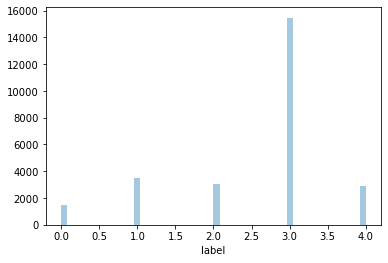

In [4]:
sns.distplot(train["label"], kde=False)

# Directory settings

In [5]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = "./"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# TRAIN_PATH = "../input/cassava-leaf-disease-classification/train_images"
TRAIN_PATH = "../input/cassava-leaf-disease-merged/train"
TEST_PATH = "../input/cassava-leaf-disease-classification/test_images"

# CFG

In [6]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug = False
    apex = True
    print_freq = 100
    num_workers = 4
    model_name = "vit_base_patch16_384"  # resnext50_32x4d, seresnext50_32x4d, tf_efficientnet_b3_ns, vit_base_patch16_384, deit_base_patch16_384
    batch_size = 16
    gradient_accumulation_steps = 2
    size = 384 if "it_base_" in model_name else 512
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]
    criterion = "BiTemperedLoss"  # ['CrossEntropyLoss', 'BiTemperedLoss']
    btl_t1 = 0.3  # Bi-Tempered Logistic Loss
    btl_t2 = 1.0
    label_smoothing = 0.2
    scheduler = "CosineAnnealingWarmRestarts"  # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts', 'CosineAnnealingWarmupRestarts']
    scheduler_batch_update = True
    epochs = 10
    # factor = 0.2  # ReduceLROnPlateau
    # patience = 4  # ReduceLROnPlateau
    # eps = 1e-6  # ReduceLROnPlateau
    # T_max = 10  # CosineAnnealingLR
    T_0 = (
        len(train) // n_fold * (n_fold - 1) // batch_size // gradient_accumulation_steps * epochs + 5
    )  # CosineAnnealingWarmRestarts
    # first_cycle_steps = (
    #     len(train) // n_fold * (n_fold - 1) // batch_size // gradient_accumulation_steps * epochs + 5
    # )  # CosineAnnealingWarmupRestarts for batch update
    # warmup_steps = first_cycle_steps // 10  # CosineAnnealingWarmupRestarts
    # gamma = 0.8  # CosineAnnealingWarmupRestarts
    lr = 1e-4
    min_lr = 2e-6
    weight_decay = 1e-6
    max_grad_norm = 1000
    seed = 4012
    target_size = 5
    target_col = "label"
    train = True
    inference = False


if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [7]:
# ====================================================
# Library
# ====================================================
import sys

sys.path.append("../input/pytorch-image-models/pytorch-image-models-master")
sys.path.append("../input/pytorchcosineannealingwithwarmup")
sys.path.append("../input/bitemperedlogloss/")
sys.path.append("../input/image-fmix/FMix-master")

import math
import os
import random
import shutil
import time
import warnings
from collections import Counter, defaultdict
from contextlib import contextmanager
from functools import partial
from pathlib import Path

import bi_tempered_loss_pytorch as btl
import cv2
import numpy as np
import pandas as pd
import scipy as sp
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from albumentations import (
    CenterCrop,
    CoarseDropout,
    Compose,
    Cutout,
    HorizontalFlip,
    HueSaturationValue,
    IAAAdditiveGaussianNoise,
    ImageOnlyTransform,
    Normalize,
    OneOf,
    RandomBrightness,
    RandomBrightnessContrast,
    RandomContrast,
    RandomCrop,
    RandomResizedCrop,
    Resize,
    Rotate,
    ShiftScaleRotate,
    Transpose,
    VerticalFlip,
)
from albumentations.pytorch import ToTensorV2
from cosine_annearing_with_warmup import CosineAnnealingWarmupRestarts
from fmix import sample_mask
from PIL import Image
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from torch.nn.parameter import Parameter
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

if CFG.apex:
    from apex import amp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utils

In [8]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=CFG.seed)

# CV split

In [9]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, "fold"] = int(n)
folds["fold"] = folds["fold"].astype(int)
print(folds.groupby(["fold", CFG.target_col]).size())

fold  label
0     0         299
      1         695
      2         604
      3        3092
      4         578
1     0         299
      1         695
      2         604
      3        3092
      4         578
2     0         298
      1         695
      2         603
      3        3093
      4         578
3     0         298
      1         695
      2         603
      3        3093
      4         578
4     0         298
      1         696
      2         603
      3        3092
      4         578
dtype: int64


# Dataset

In [10]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.labels = df["label"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TRAIN_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        label = torch.tensor(self.labels[idx]).long()
        return image, label


class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TEST_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image

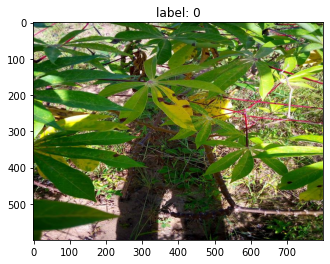

In [11]:
train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f"label: {label}")
    plt.show()

# Transforms

In [12]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):

    if data == "train":
        return Compose(
            [
                # Resize(CFG.size, CFG.size),
                RandomResizedCrop(CFG.size, CFG.size),
                Transpose(p=0.5),
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                ShiftScaleRotate(p=0.5),
                HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                CoarseDropout(p=0.5),
                Cutout(p=0.5),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    elif data == "valid":
        return Compose(
            [
                Resize(CFG.size, CFG.size),
                CenterCrop(CFG.size, CFG.size),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

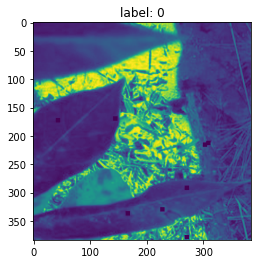

In [13]:
train_dataset = TrainDataset(train, transform=get_transforms(data="train"))

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f"label: {label}")
    plt.show()

# CutMix / FMix


In [14]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1.0 - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


def cutmix(data, target, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]

    lam = np.clip(np.random.beta(alpha, alpha), 0.3, 0.4)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, shuffled_target, lam)

    return new_data, targets


def fmix(data, targets, alpha, decay_power, shape, max_soft=0.0, reformulate=False):
    lam, mask = sample_mask(alpha, decay_power, shape, max_soft, reformulate)
    if CFG.apex:
        # mask = torch.tensor(mask, device=device).float()
        mask = mask.astype(np.float32)
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    x1 = torch.from_numpy(mask).to(device) * data
    x2 = torch.from_numpy(1 - mask).to(device) * shuffled_data
    targets = (targets, shuffled_targets, lam)

    return (x1 + x2), targets

# MixUp

In [15]:
# https://github.com/yuhao318/mwh/blob/e9e2da8fc6/utils.py
def mixup(x, y, alpha=1.0, use_cuda=True):

    """Compute the mixup data. Return mixed inputs, pairs of targets, and lambda"""
    if alpha > 0.0:
        lam = np.random.beta(alpha, alpha)
        lam = max(lam, 1 - lam)
        # lam = min(lam, 1-lam)
    else:
        lam = 1.0
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    ## SYM
    # mixed_x = lam * x + (1 - lam) * x[index,:]
    # mixed_y = (1 - lam) * x + lam * x[index,:]
    # mixed_image  = torch.cat([mixed_x,mixed_y], 0)
    # y_a, y_b = y, y[index]
    # mixed_label  = torch.cat([y_a,y_b], 0)

    ## Reduce batch size
    # new_batch_size = batch_size // 2
    # x_i = x[ : new_batch_size]
    # x_j = x[new_batch_size : ]
    # y_a = y[ : new_batch_size]
    # y_b = y[new_batch_size : ]
    # mixed_x = lam * x_i + (1 - lam) * x_j

    ## NO SYM
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    ## Only Alpha
    # mixed_x = 0.5 * x + (1 - 0.5) * x[index,:]
    # mixed_image  = mixed_x
    # y_a, y_b = y, y[index]
    # ind_label = torch.randint_like(y, 0,2)
    # mixed_label  = ind_label * y_a + (1-ind_label) * y_b

    ## Reduce batch size and SYM
    # new_batch_size = batch_size // 2
    # x_i = x[ : new_batch_size]
    # x_j = x[new_batch_size : ]
    # y_a = y[ : new_batch_size]
    # y_b = y[new_batch_size : ]
    # mixed_x = lam * x_i + (1 - lam) * x_j
    # mixed_y = (1 - lam) * x_i + lam * x_j
    # mixed_x  = torch.cat([mixed_x,mixed_y], 0)
    # y_b = torch.cat([y_b,y_a], 0)
    # y_a = y

    # return mixed_image, mixed_label, lam
    return mixed_x, (y_a, y_b, lam)

# MODEL

In [16]:
# ====================================================
# MODEL
# ====================================================
class CassvaImgClassifier(nn.Module):
    def __init__(self, model_name="resnext50_32x4d", pretrained=False):
        super().__init__()
        self.model_name = model_name

        if model_name.startswith("deit_"):
            self.model = torch.hub.load("facebookresearch/deit:main", model_name, pretrained=True)

            if model_name == "deit_base_patch16_384":
                n_features = self.model.head.in_features
                self.model.head = nn.Linear(n_features, CFG.target_size)

        else:
            self.model = timm.create_model(model_name, pretrained=pretrained)

            if "resnext50_32x4d" in model_name:
                n_features = self.model.fc.in_features
                self.model.fc = nn.Linear(n_features, CFG.target_size)

            elif model_name.startswith("tf_efficientnet"):
                n_features = self.model.classifier.in_features
                self.model.classifier = nn.Linear(n_features, CFG.target_size)

            elif model_name.startswith("vit_"):
                n_features = self.model.head.in_features
                self.model.head = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [17]:
def freeze_batch_normalization(model):
    if CFG.model_name.startswith("tf_efficientnet_"):
        for name1, child1 in model.named_children():
            for name2, child2 in child1.named_children():
                # print(f"===== {name2} =====")
                if name2.startswith("bn"):
                    for param in child2.parameters():
                        param.requires_grad = False
                        # print(param.requires_grad)

                for child3 in child2.children():
                    if isinstance(child3, nn.modules.container.Sequential):
                        for child4 in child3.children():
                            for child5 in child4.children():
                                if isinstance(child5, nn.BatchNorm2d):
                                    # print(child5)
                                    for param in child5.parameters():
                                        param.requires_grad = False
                                        # print(param.requires_grad)

    if CFG.model_name.startswith("vit_"):
        try:
            for m in model.modules():
                if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.LayerNorm):
                    m.eval()
        except ValuError:
            print("error with batchnorm2d or layernorm")
            return

In [18]:
model = CassvaImgClassifier(model_name=CFG.model_name, pretrained=False)
freeze_batch_normalization(model)
# print(model)

train_dataset = TrainDataset(train, transform=get_transforms(data="train"))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[-0.0045, -0.7661, -0.0946, -0.1649, -0.0217],
        [-0.0315, -0.5681, -0.2877, -0.5274, -0.9344],
        [-0.7614, -0.4533, -0.2327, -0.3871, -0.4727],
        [-0.4639, -0.4113, -0.1818, -0.3499, -0.5625]],
       grad_fn=<AddmmBackward>)


# Loss functions

In [19]:
class BiTemperedLogisticLoss(nn.Module):
    def __init__(self, t1, t2, smoothing=0.0):
        super(BiTemperedLogisticLoss, self).__init__()
        self.t1 = t1
        self.t2 = t2
        self.smoothing = smoothing

    def forward(self, logit_label, truth_label):
        loss_label = btl.bi_tempered_logistic_loss(
            logit_label, truth_label, t1=self.t1, t2=self.t2, label_smoothing=self.smoothing, reduction="none"
        )

        loss_label = loss_label.mean()
        return loss_label

# Helper functions

In [20]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device, scheduler_batch_update=True):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        # CutMix, FMix
        if epoch <= 1 or epoch >= CFG.epochs - 1:
            mix_decision = 0.75  # Disable CutMix, FMix for final epoch
        else:
            mix_decision = np.random.rand()

        if epoch >= CFG.epochs - 4:
            mix_decision *= 2  # Reduce probability

        if mix_decision < 0.25:
            images, labels = cutmix(images, labels, 1.0)
        elif mix_decision >= 0.25 and mix_decision < 0.5:
            images, labels = fmix(images, labels, alpha=1.0, decay_power=5.0, shape=(CFG.size, CFG.size))
        elif mix_decision >= 0.5 and mix_decision < 0.75:
            images, labels = mixup(images, labels, alpha=0.5)

        y_preds = model(images.float())

        if mix_decision < 0.75:
            loss = criterion(y_preds, labels[0]) * labels[2] + criterion(y_preds, labels[1]) * (1.0 - labels[2])
        else:
            loss = criterion(y_preds, labels)

        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

            if CFG.scheduler_batch_update:
                scheduler.step()

            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                "Epoch: [{0}][{1}/{2}] "
                # "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                # "Batch {batch_time.val:.3f} ({batch_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) "
                "Grad: {grad_norm:.4f} "
                "LR: {lr:.6f}  ".format(
                    epoch + 1,
                    step,
                    len(train_loader),
                    # batch_time=batch_time,
                    # data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(train_loader)),
                    grad_norm=grad_norm,
                    lr=scheduler.get_lr()[0],
                )
            )
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to("cpu").numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                "EVAL: [{0}/{1}] "
                # "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                # "Batch {batch_time.val:.3f} ({batch_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) ".format(
                    step,
                    len(valid_loader),
                    # batch_time=batch_time,
                    # data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(valid_loader)),
                )
            )
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state["model"])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to("cpu").numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

# Train loop

In [21]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds["fold"] != fold].index
    val_idx = folds[folds["fold"] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data="train"))
    train_dataset_no_aug = TrainDataset(train_folds, transform=get_transforms(data="valid"))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    train_loader_no_aug = DataLoader(
        train_dataset_no_aug,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer, mode="min", factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps
            )
        elif CFG.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmupRestarts":
            scheduler = CosineAnnealingWarmupRestarts(
                optimizer,
                first_cycle_steps=CFG.first_cycle_steps,
                cycle_mult=1.0,
                max_lr=CFG.lr,
                min_lr=CFG.min_lr,
                warmup_steps=CFG.warmup_steps,
                gamma=CFG.gamma,
            )
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CassvaImgClassifier(CFG.model_name, pretrained=True)
    freeze_batch_normalization(model)

    model.to(device)

    # Use multi GPU
    if device == torch.device("cuda") and not CFG.apex:
        model = torch.nn.DataParallel(model)  # make parallel
        # torch.backends.cudnn.benchmark=True

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1", verbosity=0)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if CFG.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif CFG.criterion == "BiTemperedLoss":
            criterion = BiTemperedLogisticLoss(t1=CFG.btl_t1, t2=CFG.btl_t2, smoothing=CFG.label_smoothing)
        return criterion

    criterion = get_criterion()

    # ====================================================
    # loop
    # ====================================================
    best_score = 0.0
    best_loss = np.inf

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        if epoch <= 1 or epoch >= CFG.epochs - 1:
            avg_loss = train_fn(
                train_loader_no_aug, model, criterion, optimizer, epoch, scheduler, device, CFG.scheduler_batch_update
            )
        else:
            avg_loss = train_fn(
                train_loader, model, criterion, optimizer, epoch, scheduler, device, CFG.scheduler_batch_update
            )

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values

        if not CFG.scheduler_batch_update:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(avg_val_loss)
            elif isinstance(scheduler, CosineAnnealingLR):
                scheduler.step()
            elif isinstance(scheduler, CosineAnnealingWarmRestarts):
                scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Accuracy: {score}")

        if score > best_score:
            best_score = score
            LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth"
            )

        if epoch == CFG.epochs - 1:
            LOGGER.info(f"Epoch {epoch+1} - Save final model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_final.pth"
            )

    check_point = torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth")
    valid_folds[[str(c) for c in range(5)]] = check_point["preds"]
    valid_folds["preds"] = check_point["preds"].argmax(1)

    return valid_folds

In [22]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """

    def get_result(result_df):
        preds = result_df["preds"].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f"Score: {score:<.5f}")

    if CFG.train:
        # train
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)

    if CFG.inference:
        # inference
        model = CassvaImgClassifier(CFG.model_name, pretrained=False)
        states = [torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth") for fold in CFG.trn_fold]
        test_dataset = TestDataset(test, transform=get_transforms(data="valid"))
        test_loader = DataLoader(
            test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True
        )
        predictions = inference(model, states, test_loader, device)
        # submission
        test["label"] = predictions.argmax(1)
        test[["image_id", "label"]].to_csv(OUTPUT_DIR + "submission.csv", index=False)

In [23]:
if __name__ == "__main__":
    main()

========== fold: 0 training ==========


Epoch: [1][0/1316] Elapsed 0m 1s (remain 33m 14s) Loss: 0.5794(0.5794) Grad: 1.5508 LR: 0.000100  
Epoch: [1][100/1316] Elapsed 0m 29s (remain 5m 52s) Loss: 0.0620(0.1618) Grad: 0.6770 LR: 0.000100  
Epoch: [1][200/1316] Elapsed 0m 56s (remain 5m 16s) Loss: 0.1746(0.1321) Grad: 0.6205 LR: 0.000100  
Epoch: [1][300/1316] Elapsed 1m 24s (remain 4m 46s) Loss: 0.0775(0.1234) Grad: 0.3096 LR: 0.000100  
Epoch: [1][400/1316] Elapsed 1m 52s (remain 4m 17s) Loss: 0.0577(0.1178) Grad: 0.7273 LR: 0.000100  
Epoch: [1][500/1316] Elapsed 2m 20s (remain 3m 48s) Loss: 0.1269(0.1127) Grad: 0.4751 LR: 0.000100  
Epoch: [1][600/1316] Elapsed 2m 48s (remain 3m 20s) Loss: 0.0861(0.1091) Grad: 0.5093 LR: 0.000099  
Epoch: [1][700/1316] Elapsed 3m 16s (remain 2m 52s) Loss: 0.0807(0.1056) Grad: 0.6507 LR: 0.000099  
Epoch: [1][800/1316] Elapsed 3m 43s (remain 2m 23s) Loss: 0.0916(0.1033) Grad: 0.4107 LR: 0.000099  
Epoch: [1][900/1316] Elapsed 4m 11s (remain 1m 55s) Loss: 0.0680(0.1001) Grad: 0.3385 LR: 0.0

Epoch 1 - avg_train_loss: 0.0942  avg_val_loss: 0.0750  time: 399s
Epoch 1 - Accuracy: 0.8747152619589977
Epoch 1 - Save Best Score: 0.8747 Model


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.0119(0.0750) 
Epoch: [2][0/1316] Elapsed 0m 0s (remain 21m 36s) Loss: 0.0518(0.0518) Grad: 0.2093 LR: 0.000098  
Epoch: [2][100/1316] Elapsed 0m 28s (remain 5m 46s) Loss: 0.0607(0.0613) Grad: 0.6515 LR: 0.000097  
Epoch: [2][200/1316] Elapsed 0m 56s (remain 5m 14s) Loss: 0.1083(0.0578) Grad: 0.4569 LR: 0.000097  
Epoch: [2][300/1316] Elapsed 1m 24s (remain 4m 44s) Loss: 0.0052(0.0610) Grad: 0.1117 LR: 0.000096  
Epoch: [2][400/1316] Elapsed 1m 52s (remain 4m 16s) Loss: 0.0982(0.0612) Grad: 0.3762 LR: 0.000096  
Epoch: [2][500/1316] Elapsed 2m 20s (remain 3m 48s) Loss: 0.0025(0.0612) Grad: 0.0627 LR: 0.000095  
Epoch: [2][600/1316] Elapsed 2m 48s (remain 3m 20s) Loss: 0.0654(0.0619) Grad: 0.3446 LR: 0.000095  
Epoch: [2][700/1316] Elapsed 3m 16s (remain 2m 51s) Loss: 0.0478(0.0616) Grad: 0.3664 LR: 0.000094  
Epoch: [2][800/1316] Elapsed 3m 44s (remain 2m 24s) Loss: 0.0261(0.0619) Grad: 0.3881 LR: 0.000094  
Epoch: [2][900/1316] Elap

Epoch 2 - avg_train_loss: 0.0631  avg_val_loss: 0.0759  time: 401s
Epoch 2 - Accuracy: 0.8714882308276386


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.0074(0.0759) 
Epoch: [3][0/1316] Elapsed 0m 1s (remain 24m 14s) Loss: 0.0811(0.0811) Grad: 0.4605 LR: 0.000091  
Epoch: [3][100/1316] Elapsed 0m 29s (remain 6m 0s) Loss: 0.1928(0.1346) Grad: 0.5552 LR: 0.000090  
Epoch: [3][200/1316] Elapsed 0m 59s (remain 5m 28s) Loss: 0.1511(0.1324) Grad: 0.7042 LR: 0.000089  
Epoch: [3][300/1316] Elapsed 1m 28s (remain 4m 57s) Loss: 0.1278(0.1355) Grad: 0.4176 LR: 0.000088  
Epoch: [3][400/1316] Elapsed 1m 57s (remain 4m 28s) Loss: 0.0663(0.1341) Grad: 0.3144 LR: 0.000088  
Epoch: [3][500/1316] Elapsed 2m 27s (remain 3m 59s) Loss: 0.1598(0.1353) Grad: 0.4819 LR: 0.000087  
Epoch: [3][600/1316] Elapsed 2m 56s (remain 3m 29s) Loss: 0.0939(0.1361) Grad: 0.4698 LR: 0.000086  
Epoch: [3][700/1316] Elapsed 3m 24s (remain 2m 59s) Loss: 0.1890(0.1353) Grad: 0.3756 LR: 0.000085  
Epoch: [3][800/1316] Elapsed 3m 54s (remain 2m 30s) Loss: 0.1341(0.1349) Grad: 0.2458 LR: 0.000084  
Epoch: [3][900/1316] Elaps

Epoch 3 - avg_train_loss: 0.1320  avg_val_loss: 0.0727  time: 415s
Epoch 3 - Accuracy: 0.8813591495823843
Epoch 3 - Save Best Score: 0.8814 Model


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.0375(0.0727) 
Epoch: [4][0/1316] Elapsed 0m 1s (remain 22m 57s) Loss: 0.2282(0.2282) Grad: 0.2311 LR: 0.000080  
Epoch: [4][100/1316] Elapsed 0m 30s (remain 6m 1s) Loss: 0.1166(0.1262) Grad: 0.2102 LR: 0.000079  
Epoch: [4][200/1316] Elapsed 0m 58s (remain 5m 26s) Loss: 0.1011(0.1306) Grad: 0.3382 LR: 0.000078  
Epoch: [4][300/1316] Elapsed 1m 27s (remain 4m 55s) Loss: 0.1233(0.1276) Grad: 0.3841 LR: 0.000077  
Epoch: [4][400/1316] Elapsed 1m 56s (remain 4m 26s) Loss: 0.2027(0.1291) Grad: 0.4707 LR: 0.000076  
Epoch: [4][500/1316] Elapsed 2m 25s (remain 3m 56s) Loss: 0.2004(0.1294) Grad: 0.3210 LR: 0.000075  
Epoch: [4][600/1316] Elapsed 2m 54s (remain 3m 27s) Loss: 0.1269(0.1293) Grad: 0.4369 LR: 0.000074  
Epoch: [4][700/1316] Elapsed 3m 23s (remain 2m 58s) Loss: 0.0426(0.1283) Grad: 0.6314 LR: 0.000073  
Epoch: [4][800/1316] Elapsed 3m 52s (remain 2m 29s) Loss: 0.0981(0.1286) Grad: 0.5293 LR: 0.000072  
Epoch: [4][900/1316] Elaps

Epoch 4 - avg_train_loss: 0.1276  avg_val_loss: 0.0782  time: 411s
Epoch 4 - Accuracy: 0.8697798025816249


EVAL: [329/330] Elapsed 0m 30s (remain 0m 0s) Loss: 0.0193(0.0782) 
Epoch: [5][0/1316] Elapsed 0m 1s (remain 23m 34s) Loss: 0.0269(0.0269) Grad: 0.4591 LR: 0.000066  
Epoch: [5][100/1316] Elapsed 0m 29s (remain 5m 58s) Loss: 0.1449(0.1113) Grad: 0.1427 LR: 0.000065  
Epoch: [5][200/1316] Elapsed 0m 58s (remain 5m 23s) Loss: 0.1162(0.1167) Grad: 0.3916 LR: 0.000064  
Epoch: [5][300/1316] Elapsed 1m 27s (remain 4m 53s) Loss: 0.1850(0.1232) Grad: 0.2240 LR: 0.000063  
Epoch: [5][400/1316] Elapsed 1m 55s (remain 4m 23s) Loss: 0.1377(0.1245) Grad: 0.2900 LR: 0.000062  
Epoch: [5][500/1316] Elapsed 2m 24s (remain 3m 54s) Loss: 0.0704(0.1231) Grad: 0.1215 LR: 0.000061  
Epoch: [5][600/1316] Elapsed 2m 52s (remain 3m 25s) Loss: 0.0754(0.1215) Grad: 0.2239 LR: 0.000059  
Epoch: [5][700/1316] Elapsed 3m 21s (remain 2m 56s) Loss: 0.0804(0.1200) Grad: 0.1463 LR: 0.000058  
Epoch: [5][800/1316] Elapsed 3m 49s (remain 2m 27s) Loss: 0.0464(0.1200) Grad: 0.4916 LR: 0.000057  
Epoch: [5][900/1316] Elap

Epoch 5 - avg_train_loss: 0.1217  avg_val_loss: 0.0727  time: 408s
Epoch 5 - Accuracy: 0.8775626423690205


EVAL: [329/330] Elapsed 0m 30s (remain 0m 0s) Loss: 0.0128(0.0727) 
Epoch: [6][0/1316] Elapsed 0m 1s (remain 23m 41s) Loss: 0.2198(0.2198) Grad: 0.2444 LR: 0.000051  
Epoch: [6][100/1316] Elapsed 0m 29s (remain 5m 57s) Loss: 0.1722(0.1177) Grad: 0.2204 LR: 0.000050  
Epoch: [6][200/1316] Elapsed 0m 58s (remain 5m 24s) Loss: 0.0230(0.1181) Grad: 0.2906 LR: 0.000049  
Epoch: [6][300/1316] Elapsed 1m 26s (remain 4m 53s) Loss: 0.1141(0.1166) Grad: 0.1652 LR: 0.000048  
Epoch: [6][400/1316] Elapsed 1m 55s (remain 4m 23s) Loss: 0.0045(0.1179) Grad: 0.1287 LR: 0.000046  
Epoch: [6][500/1316] Elapsed 2m 24s (remain 3m 54s) Loss: 0.1303(0.1190) Grad: 0.2090 LR: 0.000045  
Epoch: [6][600/1316] Elapsed 2m 52s (remain 3m 25s) Loss: 0.0669(0.1190) Grad: 0.6446 LR: 0.000044  
Epoch: [6][700/1316] Elapsed 3m 21s (remain 2m 56s) Loss: 0.1525(0.1197) Grad: 0.2132 LR: 0.000043  
Epoch: [6][800/1316] Elapsed 3m 49s (remain 2m 27s) Loss: 0.1690(0.1193) Grad: 0.4294 LR: 0.000042  
Epoch: [6][900/1316] Elap

Epoch 6 - avg_train_loss: 0.1185  avg_val_loss: 0.0667  time: 408s
Epoch 6 - Accuracy: 0.8815489749430524
Epoch 6 - Save Best Score: 0.8815 Model


EVAL: [329/330] Elapsed 0m 30s (remain 0m 0s) Loss: 0.0097(0.0667) 
Epoch: [7][0/1316] Elapsed 0m 1s (remain 22m 9s) Loss: 0.0107(0.0107) Grad: 0.1687 LR: 0.000036  
Epoch: [7][100/1316] Elapsed 0m 29s (remain 5m 54s) Loss: 0.0214(0.0829) Grad: 0.2404 LR: 0.000035  
Epoch: [7][200/1316] Elapsed 0m 57s (remain 5m 19s) Loss: 0.0625(0.0841) Grad: 0.2602 LR: 0.000034  
Epoch: [7][300/1316] Elapsed 1m 25s (remain 4m 49s) Loss: 0.0922(0.0849) Grad: 0.4619 LR: 0.000033  
Epoch: [7][400/1316] Elapsed 1m 53s (remain 4m 19s) Loss: 0.0074(0.0847) Grad: 0.1346 LR: 0.000032  
Epoch: [7][500/1316] Elapsed 2m 22s (remain 3m 51s) Loss: 0.0100(0.0852) Grad: 0.1651 LR: 0.000030  
Epoch: [7][600/1316] Elapsed 2m 50s (remain 3m 22s) Loss: 0.0138(0.0867) Grad: 0.2100 LR: 0.000029  
Epoch: [7][700/1316] Elapsed 3m 18s (remain 2m 54s) Loss: 0.0508(0.0872) Grad: 0.1703 LR: 0.000028  
Epoch: [7][800/1316] Elapsed 3m 46s (remain 2m 25s) Loss: 0.0121(0.0870) Grad: 0.1416 LR: 0.000027  
Epoch: [7][900/1316] Elaps

Epoch 7 - avg_train_loss: 0.0884  avg_val_loss: 0.0657  time: 403s
Epoch 7 - Accuracy: 0.8864844343204252
Epoch 7 - Save Best Score: 0.8865 Model


EVAL: [329/330] Elapsed 0m 30s (remain 0m 0s) Loss: 0.0031(0.0657) 
Epoch: [8][0/1316] Elapsed 0m 1s (remain 23m 13s) Loss: 0.0340(0.0340) Grad: 0.2127 LR: 0.000022  
Epoch: [8][100/1316] Elapsed 0m 29s (remain 5m 54s) Loss: 0.0130(0.0814) Grad: 0.2066 LR: 0.000021  
Epoch: [8][200/1316] Elapsed 0m 57s (remain 5m 19s) Loss: 0.1860(0.0867) Grad: 0.2227 LR: 0.000020  
Epoch: [8][300/1316] Elapsed 1m 25s (remain 4m 49s) Loss: 0.1121(0.0885) Grad: 0.1712 LR: 0.000020  
Epoch: [8][400/1316] Elapsed 1m 54s (remain 4m 20s) Loss: 0.2409(0.0897) Grad: 0.3688 LR: 0.000019  
Epoch: [8][500/1316] Elapsed 2m 22s (remain 3m 51s) Loss: 0.0131(0.0885) Grad: 0.1875 LR: 0.000018  
Epoch: [8][600/1316] Elapsed 2m 50s (remain 3m 22s) Loss: 0.0725(0.0868) Grad: 0.5009 LR: 0.000017  
Epoch: [8][700/1316] Elapsed 3m 18s (remain 2m 54s) Loss: 0.0504(0.0860) Grad: 0.3113 LR: 0.000016  
Epoch: [8][800/1316] Elapsed 3m 46s (remain 2m 25s) Loss: 0.0539(0.0859) Grad: 0.3364 LR: 0.000015  
Epoch: [8][900/1316] Elap

Epoch 8 - avg_train_loss: 0.0837  avg_val_loss: 0.0661  time: 402s
Epoch 8 - Accuracy: 0.8864844343204252


EVAL: [329/330] Elapsed 0m 30s (remain 0m 0s) Loss: 0.0142(0.0661) 
Epoch: [9][0/1316] Elapsed 0m 1s (remain 22m 42s) Loss: 0.0629(0.0629) Grad: 0.3279 LR: 0.000011  
Epoch: [9][100/1316] Elapsed 0m 29s (remain 5m 52s) Loss: 0.0162(0.0849) Grad: 0.3036 LR: 0.000011  
Epoch: [9][200/1316] Elapsed 0m 57s (remain 5m 17s) Loss: 0.1059(0.0826) Grad: 0.3660 LR: 0.000010  
Epoch: [9][300/1316] Elapsed 1m 25s (remain 4m 48s) Loss: 0.1051(0.0829) Grad: 0.4595 LR: 0.000009  
Epoch: [9][400/1316] Elapsed 1m 53s (remain 4m 19s) Loss: 0.1104(0.0832) Grad: 0.3982 LR: 0.000009  
Epoch: [9][500/1316] Elapsed 2m 21s (remain 3m 50s) Loss: 0.0470(0.0830) Grad: 0.4210 LR: 0.000008  
Epoch: [9][600/1316] Elapsed 2m 49s (remain 3m 22s) Loss: 0.1476(0.0829) Grad: 0.4234 LR: 0.000008  
Epoch: [9][700/1316] Elapsed 3m 18s (remain 2m 53s) Loss: 0.0346(0.0833) Grad: 0.2840 LR: 0.000007  
Epoch: [9][800/1316] Elapsed 3m 46s (remain 2m 25s) Loss: 0.0225(0.0842) Grad: 0.2916 LR: 0.000007  
Epoch: [9][900/1316] Elap

Epoch 9 - avg_train_loss: 0.0806  avg_val_loss: 0.0644  time: 402s
Epoch 9 - Accuracy: 0.889331814730448
Epoch 9 - Save Best Score: 0.8893 Model


EVAL: [329/330] Elapsed 0m 30s (remain 0m 0s) Loss: 0.0042(0.0644) 
Epoch: [10][0/1316] Elapsed 0m 0s (remain 20m 40s) Loss: 0.0610(0.0610) Grad: 0.2535 LR: 0.000004  
Epoch: [10][100/1316] Elapsed 0m 28s (remain 5m 44s) Loss: 0.0058(0.0343) Grad: 0.1475 LR: 0.000004  
Epoch: [10][200/1316] Elapsed 0m 56s (remain 5m 12s) Loss: 0.0036(0.0330) Grad: 0.0906 LR: 0.000004  
Epoch: [10][300/1316] Elapsed 1m 23s (remain 4m 43s) Loss: 0.0043(0.0346) Grad: 0.0908 LR: 0.000003  
Epoch: [10][400/1316] Elapsed 1m 51s (remain 4m 14s) Loss: 0.0381(0.0341) Grad: 0.3217 LR: 0.000003  
Epoch: [10][500/1316] Elapsed 2m 19s (remain 3m 47s) Loss: 0.0227(0.0340) Grad: 0.2869 LR: 0.000003  
Epoch: [10][600/1316] Elapsed 2m 47s (remain 3m 19s) Loss: 0.0340(0.0336) Grad: 0.3269 LR: 0.000003  
Epoch: [10][700/1316] Elapsed 3m 15s (remain 2m 51s) Loss: 0.0455(0.0329) Grad: 0.2140 LR: 0.000003  
Epoch: [10][800/1316] Elapsed 3m 43s (remain 2m 23s) Loss: 0.0013(0.0328) Grad: 0.0493 LR: 0.000002  
Epoch: [10][900/

Epoch 10 - avg_train_loss: 0.0320  avg_val_loss: 0.0645  time: 399s
Epoch 10 - Accuracy: 0.8887623386484435
Epoch 10 - Save final model


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.0036(0.0645) 


========== fold: 0 result ==========
Score: 0.88933
========== fold: 1 training ==========


Epoch: [1][0/1316] Elapsed 0m 1s (remain 22m 12s) Loss: 0.3938(0.3938) Grad: 1.0752 LR: 0.000100  
Epoch: [1][100/1316] Elapsed 0m 29s (remain 6m 0s) Loss: 0.0506(0.1542) Grad: 0.5262 LR: 0.000100  
Epoch: [1][200/1316] Elapsed 0m 58s (remain 5m 25s) Loss: 0.1708(0.1338) Grad: 1.1141 LR: 0.000100  
Epoch: [1][300/1316] Elapsed 1m 27s (remain 4m 54s) Loss: 0.1212(0.1227) Grad: 0.6295 LR: 0.000100  
Epoch: [1][400/1316] Elapsed 1m 56s (remain 4m 25s) Loss: 0.1585(0.1160) Grad: 0.5976 LR: 0.000100  
Epoch: [1][500/1316] Elapsed 2m 24s (remain 3m 55s) Loss: 0.0234(0.1121) Grad: 0.3520 LR: 0.000100  
Epoch: [1][600/1316] Elapsed 2m 53s (remain 3m 26s) Loss: 0.0632(0.1083) Grad: 0.5974 LR: 0.000099  
Epoch: [1][700/1316] Elapsed 3m 22s (remain 2m 57s) Loss: 0.0813(0.1048) Grad: 0.5535 LR: 0.000099  
Epoch: [1][800/1316] Elapsed 3m 50s (remain 2m 28s) Loss: 0.0833(0.1030) Grad: 0.5260 LR: 0.000099  
Epoch: [1][900/1316] Elapsed 4m 19s (remain 1m 59s) Loss: 0.0592(0.1012) Grad: 0.6174 LR: 0.00

Epoch 1 - avg_train_loss: 0.0949  avg_val_loss: 0.0835  time: 410s
Epoch 1 - Accuracy: 0.8599088838268792
Epoch 1 - Save Best Score: 0.8599 Model


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.1781(0.0835) 
Epoch: [2][0/1316] Elapsed 0m 0s (remain 21m 34s) Loss: 0.0759(0.0759) Grad: 0.3035 LR: 0.000098  
Epoch: [2][100/1316] Elapsed 0m 29s (remain 5m 55s) Loss: 0.1273(0.0570) Grad: 0.4411 LR: 0.000097  
Epoch: [2][200/1316] Elapsed 0m 58s (remain 5m 22s) Loss: 0.0145(0.0580) Grad: 0.3240 LR: 0.000097  
Epoch: [2][300/1316] Elapsed 1m 26s (remain 4m 51s) Loss: 0.1398(0.0575) Grad: 0.4806 LR: 0.000096  
Epoch: [2][400/1316] Elapsed 1m 55s (remain 4m 22s) Loss: 0.1532(0.0589) Grad: 0.6860 LR: 0.000096  
Epoch: [2][500/1316] Elapsed 2m 23s (remain 3m 53s) Loss: 0.0898(0.0598) Grad: 0.6051 LR: 0.000095  
Epoch: [2][600/1316] Elapsed 2m 52s (remain 3m 25s) Loss: 0.0632(0.0596) Grad: 0.3273 LR: 0.000095  
Epoch: [2][700/1316] Elapsed 3m 21s (remain 2m 56s) Loss: 0.1574(0.0601) Grad: 0.6752 LR: 0.000094  
Epoch: [2][800/1316] Elapsed 3m 49s (remain 2m 27s) Loss: 0.0497(0.0595) Grad: 0.4030 LR: 0.000094  
Epoch: [2][900/1316] Elap

Epoch 2 - avg_train_loss: 0.0612  avg_val_loss: 0.0769  time: 409s
Epoch 2 - Accuracy: 0.8712984054669703
Epoch 2 - Save Best Score: 0.8713 Model


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.2423(0.0769) 
Epoch: [3][0/1316] Elapsed 0m 1s (remain 24m 22s) Loss: 0.1564(0.1564) Grad: 0.2926 LR: 0.000091  
Epoch: [3][100/1316] Elapsed 0m 30s (remain 6m 11s) Loss: 0.1854(0.1545) Grad: 0.3667 LR: 0.000090  
Epoch: [3][200/1316] Elapsed 1m 0s (remain 5m 34s) Loss: 0.0962(0.1424) Grad: 0.3435 LR: 0.000089  
Epoch: [3][300/1316] Elapsed 1m 29s (remain 5m 3s) Loss: 0.2087(0.1414) Grad: 0.4175 LR: 0.000088  
Epoch: [3][400/1316] Elapsed 1m 59s (remain 4m 33s) Loss: 0.0663(0.1369) Grad: 0.3258 LR: 0.000088  
Epoch: [3][500/1316] Elapsed 2m 29s (remain 4m 2s) Loss: 0.1205(0.1347) Grad: 0.1768 LR: 0.000087  
Epoch: [3][600/1316] Elapsed 2m 59s (remain 3m 33s) Loss: 0.1077(0.1343) Grad: 0.3037 LR: 0.000086  
Epoch: [3][700/1316] Elapsed 3m 28s (remain 3m 3s) Loss: 0.1337(0.1337) Grad: 0.3110 LR: 0.000085  
Epoch: [3][800/1316] Elapsed 3m 58s (remain 2m 33s) Loss: 0.0733(0.1333) Grad: 0.3598 LR: 0.000084  
Epoch: [3][900/1316] Elapsed 

Epoch 3 - avg_train_loss: 0.1321  avg_val_loss: 0.0750  time: 423s
Epoch 3 - Accuracy: 0.8737661351556568
Epoch 3 - Save Best Score: 0.8738 Model


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.1480(0.0750) 
Epoch: [4][0/1316] Elapsed 0m 1s (remain 24m 28s) Loss: 0.0721(0.0721) Grad: 0.3545 LR: 0.000080  
Epoch: [4][100/1316] Elapsed 0m 30s (remain 6m 10s) Loss: 0.0615(0.1228) Grad: 0.3400 LR: 0.000079  
Epoch: [4][200/1316] Elapsed 1m 0s (remain 5m 36s) Loss: 0.1090(0.1253) Grad: 0.2296 LR: 0.000078  
Epoch: [4][300/1316] Elapsed 1m 30s (remain 5m 4s) Loss: 0.1733(0.1255) Grad: 0.3332 LR: 0.000077  
Epoch: [4][400/1316] Elapsed 2m 0s (remain 4m 33s) Loss: 0.1362(0.1270) Grad: 0.2556 LR: 0.000076  
Epoch: [4][500/1316] Elapsed 2m 29s (remain 4m 3s) Loss: 0.1475(0.1263) Grad: 0.3920 LR: 0.000075  
Epoch: [4][600/1316] Elapsed 2m 59s (remain 3m 33s) Loss: 0.0283(0.1261) Grad: 0.1491 LR: 0.000074  
Epoch: [4][700/1316] Elapsed 3m 28s (remain 3m 3s) Loss: 0.0560(0.1257) Grad: 0.1916 LR: 0.000073  
Epoch: [4][800/1316] Elapsed 3m 58s (remain 2m 33s) Loss: 0.1701(0.1253) Grad: 0.2882 LR: 0.000072  
Epoch: [4][900/1316] Elapsed 4

Epoch 4 - avg_train_loss: 0.1250  avg_val_loss: 0.0728  time: 423s
Epoch 4 - Accuracy: 0.8785117691723614
Epoch 4 - Save Best Score: 0.8785 Model


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.1501(0.0728) 
Epoch: [5][0/1316] Elapsed 0m 1s (remain 25m 28s) Loss: 0.1205(0.1205) Grad: 0.3345 LR: 0.000066  
Epoch: [5][100/1316] Elapsed 0m 30s (remain 6m 10s) Loss: 0.1856(0.1302) Grad: 0.5525 LR: 0.000065  
Epoch: [5][200/1316] Elapsed 1m 0s (remain 5m 34s) Loss: 0.1046(0.1279) Grad: 0.2798 LR: 0.000064  
Epoch: [5][300/1316] Elapsed 1m 29s (remain 5m 2s) Loss: 0.1619(0.1245) Grad: 0.2699 LR: 0.000063  
Epoch: [5][400/1316] Elapsed 1m 59s (remain 4m 32s) Loss: 0.1215(0.1255) Grad: 0.1789 LR: 0.000062  
Epoch: [5][500/1316] Elapsed 2m 29s (remain 4m 2s) Loss: 0.0623(0.1264) Grad: 0.1854 LR: 0.000061  
Epoch: [5][600/1316] Elapsed 2m 58s (remain 3m 32s) Loss: 0.0580(0.1258) Grad: 0.3491 LR: 0.000059  
Epoch: [5][700/1316] Elapsed 3m 28s (remain 3m 2s) Loss: 0.1113(0.1250) Grad: 0.3659 LR: 0.000058  
Epoch: [5][800/1316] Elapsed 3m 57s (remain 2m 32s) Loss: 0.0966(0.1248) Grad: 0.2022 LR: 0.000057  
Epoch: [5][900/1316] Elapsed 

Epoch 5 - avg_train_loss: 0.1224  avg_val_loss: 0.0722  time: 421s
Epoch 5 - Accuracy: 0.8737661351556568


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.2496(0.0722) 
Epoch: [6][0/1316] Elapsed 0m 1s (remain 24m 58s) Loss: 0.1145(0.1145) Grad: 0.2936 LR: 0.000051  
Epoch: [6][100/1316] Elapsed 0m 30s (remain 6m 9s) Loss: 0.1693(0.1264) Grad: 0.1579 LR: 0.000050  
Epoch: [6][200/1316] Elapsed 1m 0s (remain 5m 33s) Loss: 0.0251(0.1255) Grad: 0.3345 LR: 0.000049  
Epoch: [6][300/1316] Elapsed 1m 29s (remain 5m 2s) Loss: 0.1477(0.1220) Grad: 0.2828 LR: 0.000048  
Epoch: [6][400/1316] Elapsed 1m 59s (remain 4m 32s) Loss: 0.0198(0.1198) Grad: 0.1800 LR: 0.000046  
Epoch: [6][500/1316] Elapsed 2m 29s (remain 4m 2s) Loss: 0.2018(0.1191) Grad: 0.3386 LR: 0.000045  
Epoch: [6][600/1316] Elapsed 2m 58s (remain 3m 32s) Loss: 0.1113(0.1183) Grad: 0.2086 LR: 0.000044  
Epoch: [6][700/1316] Elapsed 3m 28s (remain 3m 2s) Loss: 0.1039(0.1171) Grad: 0.3615 LR: 0.000043  
Epoch: [6][800/1316] Elapsed 3m 57s (remain 2m 32s) Loss: 0.1001(0.1180) Grad: 0.2412 LR: 0.000042  
Epoch: [6][900/1316] Elapsed 4

Epoch 6 - avg_train_loss: 0.1195  avg_val_loss: 0.0702  time: 420s
Epoch 6 - Accuracy: 0.8787015945330297
Epoch 6 - Save Best Score: 0.8787 Model


EVAL: [329/330] Elapsed 0m 30s (remain 0m 0s) Loss: 0.1658(0.0702) 
Epoch: [7][0/1316] Elapsed 0m 1s (remain 25m 34s) Loss: 0.1515(0.1515) Grad: 0.3249 LR: 0.000036  
Epoch: [7][100/1316] Elapsed 0m 30s (remain 6m 5s) Loss: 0.0466(0.0824) Grad: 0.2120 LR: 0.000035  
Epoch: [7][200/1316] Elapsed 0m 59s (remain 5m 29s) Loss: 0.1246(0.0882) Grad: 0.3913 LR: 0.000034  
Epoch: [7][300/1316] Elapsed 1m 28s (remain 4m 58s) Loss: 0.0720(0.0886) Grad: 0.5792 LR: 0.000033  
Epoch: [7][400/1316] Elapsed 1m 57s (remain 4m 28s) Loss: 0.0822(0.0887) Grad: 0.5478 LR: 0.000032  
Epoch: [7][500/1316] Elapsed 2m 26s (remain 3m 58s) Loss: 0.0680(0.0865) Grad: 0.4421 LR: 0.000030  
Epoch: [7][600/1316] Elapsed 2m 55s (remain 3m 29s) Loss: 0.0103(0.0874) Grad: 0.1951 LR: 0.000029  
Epoch: [7][700/1316] Elapsed 3m 24s (remain 2m 59s) Loss: 0.0299(0.0870) Grad: 0.3965 LR: 0.000028  
Epoch: [7][800/1316] Elapsed 3m 54s (remain 2m 30s) Loss: 0.1569(0.0863) Grad: 0.2447 LR: 0.000027  
Epoch: [7][900/1316] Elaps

Epoch 7 - avg_train_loss: 0.0869  avg_val_loss: 0.0716  time: 415s
Epoch 7 - Accuracy: 0.8802201974183751
Epoch 7 - Save Best Score: 0.8802 Model


EVAL: [329/330] Elapsed 0m 30s (remain 0m 0s) Loss: 0.1437(0.0716) 
Epoch: [8][0/1316] Elapsed 0m 1s (remain 24m 10s) Loss: 0.0084(0.0084) Grad: 0.1289 LR: 0.000022  
Epoch: [8][100/1316] Elapsed 0m 30s (remain 6m 4s) Loss: 0.0578(0.0928) Grad: 0.6008 LR: 0.000021  
Epoch: [8][200/1316] Elapsed 0m 59s (remain 5m 28s) Loss: 0.0577(0.0864) Grad: 0.1549 LR: 0.000020  
Epoch: [8][300/1316] Elapsed 1m 28s (remain 4m 57s) Loss: 0.1369(0.0839) Grad: 0.3428 LR: 0.000020  
Epoch: [8][400/1316] Elapsed 1m 57s (remain 4m 27s) Loss: 0.2176(0.0835) Grad: 0.3693 LR: 0.000019  
Epoch: [8][500/1316] Elapsed 2m 26s (remain 3m 57s) Loss: 0.0182(0.0837) Grad: 0.2678 LR: 0.000018  
Epoch: [8][600/1316] Elapsed 2m 55s (remain 3m 28s) Loss: 0.2497(0.0863) Grad: 0.2575 LR: 0.000017  
Epoch: [8][700/1316] Elapsed 3m 24s (remain 2m 59s) Loss: 0.0474(0.0860) Grad: 0.2975 LR: 0.000016  
Epoch: [8][800/1316] Elapsed 3m 53s (remain 2m 29s) Loss: 0.0863(0.0856) Grad: 0.3137 LR: 0.000015  
Epoch: [8][900/1316] Elaps

Epoch 8 - avg_train_loss: 0.0821  avg_val_loss: 0.0704  time: 413s
Epoch 8 - Accuracy: 0.8813591495823843
Epoch 8 - Save Best Score: 0.8814 Model


EVAL: [329/330] Elapsed 0m 30s (remain 0m 0s) Loss: 0.1501(0.0704) 
Epoch: [9][0/1316] Elapsed 0m 1s (remain 25m 14s) Loss: 0.0813(0.0813) Grad: 0.2993 LR: 0.000011  
Epoch: [9][100/1316] Elapsed 0m 30s (remain 6m 4s) Loss: 0.0569(0.0763) Grad: 0.2445 LR: 0.000011  
Epoch: [9][200/1316] Elapsed 0m 59s (remain 5m 27s) Loss: 0.0256(0.0788) Grad: 0.1924 LR: 0.000010  
Epoch: [9][300/1316] Elapsed 1m 28s (remain 4m 57s) Loss: 0.1143(0.0794) Grad: 0.4793 LR: 0.000009  
Epoch: [9][400/1316] Elapsed 1m 57s (remain 4m 27s) Loss: 0.0956(0.0784) Grad: 0.7019 LR: 0.000009  
Epoch: [9][500/1316] Elapsed 2m 26s (remain 3m 57s) Loss: 0.2148(0.0794) Grad: 0.4088 LR: 0.000008  
Epoch: [9][600/1316] Elapsed 2m 55s (remain 3m 28s) Loss: 0.2126(0.0792) Grad: 0.4287 LR: 0.000008  
Epoch: [9][700/1316] Elapsed 3m 24s (remain 2m 59s) Loss: 0.0285(0.0788) Grad: 0.3012 LR: 0.000007  
Epoch: [9][800/1316] Elapsed 3m 53s (remain 2m 30s) Loss: 0.0035(0.0787) Grad: 0.0745 LR: 0.000007  
Epoch: [9][900/1316] Elaps

Epoch 9 - avg_train_loss: 0.0791  avg_val_loss: 0.0685  time: 418s
Epoch 9 - Accuracy: 0.8836370539104025
Epoch 9 - Save Best Score: 0.8836 Model


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.1833(0.0685) 
Epoch: [10][0/1316] Elapsed 0m 1s (remain 23m 42s) Loss: 0.0502(0.0502) Grad: 0.2274 LR: 0.000004  
Epoch: [10][100/1316] Elapsed 0m 29s (remain 5m 57s) Loss: 0.0914(0.0354) Grad: 0.3171 LR: 0.000004  
Epoch: [10][200/1316] Elapsed 0m 58s (remain 5m 24s) Loss: 0.0708(0.0320) Grad: 0.8493 LR: 0.000004  
Epoch: [10][300/1316] Elapsed 1m 27s (remain 4m 54s) Loss: 0.0041(0.0314) Grad: 0.0841 LR: 0.000003  
Epoch: [10][400/1316] Elapsed 1m 56s (remain 4m 25s) Loss: 0.0415(0.0299) Grad: 0.1948 LR: 0.000003  
Epoch: [10][500/1316] Elapsed 2m 25s (remain 3m 55s) Loss: 0.0523(0.0301) Grad: 0.1838 LR: 0.000003  
Epoch: [10][600/1316] Elapsed 2m 53s (remain 3m 26s) Loss: 0.0485(0.0304) Grad: 0.3507 LR: 0.000003  
Epoch: [10][700/1316] Elapsed 3m 22s (remain 2m 57s) Loss: 0.0217(0.0301) Grad: 0.3630 LR: 0.000003  
Epoch: [10][800/1316] Elapsed 3m 50s (remain 2m 28s) Loss: 0.0495(0.0301) Grad: 0.2497 LR: 0.000002  
Epoch: [10][900/

Epoch 10 - avg_train_loss: 0.0298  avg_val_loss: 0.0687  time: 409s
Epoch 10 - Accuracy: 0.8857251328777525
Epoch 10 - Save Best Score: 0.8857 Model


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.1591(0.0687) 


Epoch 10 - Save final model
========== fold: 1 result ==========
Score: 0.88573
========== fold: 2 training ==========


Epoch: [1][0/1316] Elapsed 0m 1s (remain 21m 56s) Loss: 0.3502(0.3502) Grad: 1.5674 LR: 0.000100  
Epoch: [1][100/1316] Elapsed 0m 30s (remain 6m 5s) Loss: 0.1129(0.1630) Grad: 0.5336 LR: 0.000100  
Epoch: [1][200/1316] Elapsed 0m 59s (remain 5m 31s) Loss: 0.0570(0.1322) Grad: 0.3947 LR: 0.000100  
Epoch: [1][300/1316] Elapsed 1m 29s (remain 5m 0s) Loss: 0.0921(0.1191) Grad: 0.8923 LR: 0.000100  
Epoch: [1][400/1316] Elapsed 1m 58s (remain 4m 29s) Loss: 0.0831(0.1131) Grad: 0.5532 LR: 0.000100  
Epoch: [1][500/1316] Elapsed 2m 27s (remain 4m 0s) Loss: 0.0293(0.1107) Grad: 0.3575 LR: 0.000100  
Epoch: [1][600/1316] Elapsed 2m 56s (remain 3m 30s) Loss: 0.0526(0.1068) Grad: 0.6075 LR: 0.000099  
Epoch: [1][700/1316] Elapsed 3m 26s (remain 3m 0s) Loss: 0.0325(0.1038) Grad: 0.2935 LR: 0.000099  
Epoch: [1][800/1316] Elapsed 3m 55s (remain 2m 31s) Loss: 0.1387(0.1004) Grad: 0.9193 LR: 0.000099  
Epoch: [1][900/1316] Elapsed 4m 24s (remain 2m 2s) Loss: 0.0592(0.0992) Grad: 0.3632 LR: 0.000099

Epoch 1 - avg_train_loss: 0.0937  avg_val_loss: 0.0768  time: 418s
Epoch 1 - Accuracy: 0.8708942471995443
Epoch 1 - Save Best Score: 0.8709 Model


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.1557(0.0768) 
Epoch: [2][0/1316] Elapsed 0m 1s (remain 22m 21s) Loss: 0.0511(0.0511) Grad: 0.1941 LR: 0.000098  
Epoch: [2][100/1316] Elapsed 0m 30s (remain 6m 4s) Loss: 0.0073(0.0535) Grad: 0.1417 LR: 0.000097  
Epoch: [2][200/1316] Elapsed 0m 59s (remain 5m 30s) Loss: 0.0756(0.0562) Grad: 0.4073 LR: 0.000097  
Epoch: [2][300/1316] Elapsed 1m 28s (remain 4m 59s) Loss: 0.0566(0.0580) Grad: 0.2191 LR: 0.000096  
Epoch: [2][400/1316] Elapsed 1m 58s (remain 4m 29s) Loss: 0.0074(0.0603) Grad: 0.1665 LR: 0.000096  
Epoch: [2][500/1316] Elapsed 2m 27s (remain 3m 59s) Loss: 0.0558(0.0605) Grad: 0.3246 LR: 0.000095  
Epoch: [2][600/1316] Elapsed 2m 56s (remain 3m 29s) Loss: 0.0534(0.0609) Grad: 0.4327 LR: 0.000095  
Epoch: [2][700/1316] Elapsed 3m 25s (remain 3m 0s) Loss: 0.1029(0.0610) Grad: 0.8566 LR: 0.000094  
Epoch: [2][800/1316] Elapsed 3m 54s (remain 2m 31s) Loss: 0.0197(0.0616) Grad: 0.3299 LR: 0.000094  
Epoch: [2][900/1316] Elapse

Epoch 2 - avg_train_loss: 0.0624  avg_val_loss: 0.0798  time: 417s
Epoch 2 - Accuracy: 0.8632997911524587


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.2442(0.0798) 
Epoch: [3][0/1316] Elapsed 0m 1s (remain 23m 58s) Loss: 0.0850(0.0850) Grad: 0.3972 LR: 0.000091  
Epoch: [3][100/1316] Elapsed 0m 31s (remain 6m 14s) Loss: 0.1982(0.1573) Grad: 0.2330 LR: 0.000090  
Epoch: [3][200/1316] Elapsed 1m 1s (remain 5m 39s) Loss: 0.1080(0.1510) Grad: 0.7524 LR: 0.000089  
Epoch: [3][300/1316] Elapsed 1m 31s (remain 5m 7s) Loss: 0.1047(0.1459) Grad: 0.3631 LR: 0.000088  
Epoch: [3][400/1316] Elapsed 2m 1s (remain 4m 36s) Loss: 0.2325(0.1417) Grad: 0.4415 LR: 0.000088  
Epoch: [3][500/1316] Elapsed 2m 31s (remain 4m 6s) Loss: 0.0737(0.1386) Grad: 0.2725 LR: 0.000087  
Epoch: [3][600/1316] Elapsed 3m 1s (remain 3m 35s) Loss: 0.1048(0.1376) Grad: 0.5473 LR: 0.000086  
Epoch: [3][700/1316] Elapsed 3m 31s (remain 3m 5s) Loss: 0.2182(0.1362) Grad: 0.2940 LR: 0.000085  
Epoch: [3][800/1316] Elapsed 4m 1s (remain 2m 35s) Loss: 0.1634(0.1348) Grad: 0.3729 LR: 0.000084  
Epoch: [3][900/1316] Elapsed 4m 

Epoch 3 - avg_train_loss: 0.1325  avg_val_loss: 0.0709  time: 428s
Epoch 3 - Accuracy: 0.8786785646478071
Epoch 3 - Save Best Score: 0.8787 Model


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.1766(0.0709) 
Epoch: [4][0/1316] Elapsed 0m 1s (remain 24m 16s) Loss: 0.1486(0.1486) Grad: 0.1742 LR: 0.000080  
Epoch: [4][100/1316] Elapsed 0m 31s (remain 6m 15s) Loss: 0.0953(0.1255) Grad: 0.2014 LR: 0.000079  
Epoch: [4][200/1316] Elapsed 1m 1s (remain 5m 40s) Loss: 0.1086(0.1273) Grad: 0.5497 LR: 0.000078  
Epoch: [4][300/1316] Elapsed 1m 31s (remain 5m 9s) Loss: 0.1175(0.1271) Grad: 0.1709 LR: 0.000077  
Epoch: [4][400/1316] Elapsed 2m 2s (remain 4m 38s) Loss: 0.0647(0.1248) Grad: 0.6161 LR: 0.000076  
Epoch: [4][500/1316] Elapsed 2m 32s (remain 4m 8s) Loss: 0.1709(0.1283) Grad: 0.5220 LR: 0.000075  
Epoch: [4][600/1316] Elapsed 3m 3s (remain 3m 38s) Loss: 0.0727(0.1276) Grad: 0.3683 LR: 0.000074  
Epoch: [4][700/1316] Elapsed 3m 34s (remain 3m 7s) Loss: 0.2010(0.1279) Grad: 0.4525 LR: 0.000073  
Epoch: [4][800/1316] Elapsed 4m 4s (remain 2m 37s) Loss: 0.1022(0.1270) Grad: 0.3610 LR: 0.000072  
Epoch: [4][900/1316] Elapsed 4m 

Epoch 4 - avg_train_loss: 0.1264  avg_val_loss: 0.0713  time: 434s
Epoch 4 - Accuracy: 0.8788684260489843
Epoch 4 - Save Best Score: 0.8789 Model


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.2430(0.0713) 
Epoch: [5][0/1316] Elapsed 0m 1s (remain 25m 54s) Loss: 0.1384(0.1384) Grad: 0.3855 LR: 0.000066  
Epoch: [5][100/1316] Elapsed 0m 31s (remain 6m 20s) Loss: 0.1743(0.1208) Grad: 0.3210 LR: 0.000065  
Epoch: [5][200/1316] Elapsed 1m 1s (remain 5m 43s) Loss: 0.0851(0.1279) Grad: 0.1459 LR: 0.000064  
Epoch: [5][300/1316] Elapsed 1m 31s (remain 5m 9s) Loss: 0.0720(0.1273) Grad: 0.2458 LR: 0.000063  
Epoch: [5][400/1316] Elapsed 2m 1s (remain 4m 37s) Loss: 0.0855(0.1251) Grad: 0.4899 LR: 0.000062  
Epoch: [5][500/1316] Elapsed 2m 31s (remain 4m 6s) Loss: 0.0496(0.1262) Grad: 0.1325 LR: 0.000061  
Epoch: [5][600/1316] Elapsed 3m 1s (remain 3m 35s) Loss: 0.1130(0.1263) Grad: 0.4221 LR: 0.000059  
Epoch: [5][700/1316] Elapsed 3m 31s (remain 3m 5s) Loss: 0.0147(0.1245) Grad: 0.2386 LR: 0.000058  
Epoch: [5][800/1316] Elapsed 4m 1s (remain 2m 35s) Loss: 0.0905(0.1253) Grad: 0.2600 LR: 0.000057  
Epoch: [5][900/1316] Elapsed 4m 

Epoch 5 - avg_train_loss: 0.1227  avg_val_loss: 0.0703  time: 426s
Epoch 5 - Accuracy: 0.8803873172584014
Epoch 5 - Save Best Score: 0.8804 Model


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.1796(0.0703) 
Epoch: [6][0/1316] Elapsed 0m 1s (remain 24m 56s) Loss: 0.1884(0.1884) Grad: 0.3291 LR: 0.000051  
Epoch: [6][100/1316] Elapsed 0m 31s (remain 6m 15s) Loss: 0.1098(0.1266) Grad: 0.2408 LR: 0.000050  
Epoch: [6][200/1316] Elapsed 1m 0s (remain 5m 38s) Loss: 0.0941(0.1209) Grad: 0.4568 LR: 0.000049  
Epoch: [6][300/1316] Elapsed 1m 30s (remain 5m 5s) Loss: 0.0506(0.1201) Grad: 0.2968 LR: 0.000048  
Epoch: [6][400/1316] Elapsed 2m 0s (remain 4m 34s) Loss: 0.1168(0.1197) Grad: 0.3980 LR: 0.000046  
Epoch: [6][500/1316] Elapsed 2m 29s (remain 4m 3s) Loss: 0.1785(0.1209) Grad: 0.4035 LR: 0.000045  
Epoch: [6][600/1316] Elapsed 2m 59s (remain 3m 33s) Loss: 0.0850(0.1197) Grad: 0.3459 LR: 0.000044  
Epoch: [6][700/1316] Elapsed 3m 29s (remain 3m 3s) Loss: 0.0433(0.1189) Grad: 0.1195 LR: 0.000043  
Epoch: [6][800/1316] Elapsed 3m 59s (remain 2m 33s) Loss: 0.1317(0.1189) Grad: 0.1423 LR: 0.000042  
Epoch: [6][900/1316] Elapsed 4

Epoch 6 - avg_train_loss: 0.1184  avg_val_loss: 0.0692  time: 426s
Epoch 6 - Accuracy: 0.8822859312701727
Epoch 6 - Save Best Score: 0.8823 Model


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.1141(0.0692) 
Epoch: [7][0/1316] Elapsed 0m 1s (remain 25m 48s) Loss: 0.0800(0.0800) Grad: 0.4699 LR: 0.000036  
Epoch: [7][100/1316] Elapsed 0m 31s (remain 6m 12s) Loss: 0.0534(0.0835) Grad: 0.3598 LR: 0.000035  
Epoch: [7][200/1316] Elapsed 1m 1s (remain 5m 38s) Loss: 0.1217(0.0851) Grad: 0.3691 LR: 0.000034  
Epoch: [7][300/1316] Elapsed 1m 31s (remain 5m 7s) Loss: 0.0487(0.0847) Grad: 0.3916 LR: 0.000033  
Epoch: [7][400/1316] Elapsed 2m 1s (remain 4m 37s) Loss: 0.1181(0.0852) Grad: 0.2829 LR: 0.000032  
Epoch: [7][500/1316] Elapsed 2m 31s (remain 4m 6s) Loss: 0.0831(0.0865) Grad: 0.2352 LR: 0.000030  
Epoch: [7][600/1316] Elapsed 3m 1s (remain 3m 36s) Loss: 0.2169(0.0876) Grad: 0.3384 LR: 0.000029  
Epoch: [7][700/1316] Elapsed 3m 32s (remain 3m 6s) Loss: 0.0632(0.0870) Grad: 0.2552 LR: 0.000028  
Epoch: [7][800/1316] Elapsed 4m 2s (remain 2m 36s) Loss: 0.0798(0.0863) Grad: 0.5186 LR: 0.000027  
Epoch: [7][900/1316] Elapsed 4m 

Epoch 7 - avg_train_loss: 0.0875  avg_val_loss: 0.0658  time: 430s
Epoch 7 - Accuracy: 0.8855135750901841
Epoch 7 - Save Best Score: 0.8855 Model


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.0514(0.0658) 
Epoch: [8][0/1316] Elapsed 0m 1s (remain 24m 43s) Loss: 0.0415(0.0415) Grad: 0.6152 LR: 0.000022  
Epoch: [8][100/1316] Elapsed 0m 31s (remain 6m 21s) Loss: 0.1461(0.0829) Grad: 0.3630 LR: 0.000021  
Epoch: [8][200/1316] Elapsed 1m 1s (remain 5m 42s) Loss: 0.0117(0.0785) Grad: 0.2633 LR: 0.000020  
Epoch: [8][300/1316] Elapsed 1m 31s (remain 5m 8s) Loss: 0.0338(0.0813) Grad: 0.2328 LR: 0.000020  
Epoch: [8][400/1316] Elapsed 2m 1s (remain 4m 36s) Loss: 0.1719(0.0843) Grad: 0.3341 LR: 0.000019  
Epoch: [8][500/1316] Elapsed 2m 30s (remain 4m 5s) Loss: 0.1787(0.0844) Grad: 0.3091 LR: 0.000018  
Epoch: [8][600/1316] Elapsed 3m 0s (remain 3m 34s) Loss: 0.0079(0.0846) Grad: 0.1448 LR: 0.000017  
Epoch: [8][700/1316] Elapsed 3m 30s (remain 3m 4s) Loss: 0.1372(0.0848) Grad: 0.2812 LR: 0.000016  
Epoch: [8][800/1316] Elapsed 3m 59s (remain 2m 34s) Loss: 0.2613(0.0850) Grad: 0.5991 LR: 0.000015  
Epoch: [8][900/1316] Elapsed 4m

Epoch 8 - avg_train_loss: 0.0853  avg_val_loss: 0.0656  time: 424s
Epoch 8 - Accuracy: 0.886652743497247
Epoch 8 - Save Best Score: 0.8867 Model


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.0588(0.0656) 
Epoch: [9][0/1316] Elapsed 0m 1s (remain 24m 28s) Loss: 0.0944(0.0944) Grad: 0.4043 LR: 0.000011  
Epoch: [9][100/1316] Elapsed 0m 30s (remain 6m 11s) Loss: 0.0487(0.0817) Grad: 0.3834 LR: 0.000011  
Epoch: [9][200/1316] Elapsed 1m 0s (remain 5m 37s) Loss: 0.0265(0.0831) Grad: 0.3411 LR: 0.000010  
Epoch: [9][300/1316] Elapsed 1m 30s (remain 5m 5s) Loss: 0.2050(0.0829) Grad: 0.2195 LR: 0.000009  
Epoch: [9][400/1316] Elapsed 2m 0s (remain 4m 34s) Loss: 0.0686(0.0838) Grad: 0.4801 LR: 0.000009  
Epoch: [9][500/1316] Elapsed 2m 29s (remain 4m 3s) Loss: 0.1991(0.0842) Grad: 0.3076 LR: 0.000008  
Epoch: [9][600/1316] Elapsed 2m 59s (remain 3m 33s) Loss: 0.1142(0.0847) Grad: 0.4413 LR: 0.000008  
Epoch: [9][700/1316] Elapsed 3m 29s (remain 3m 3s) Loss: 0.1382(0.0839) Grad: 0.1892 LR: 0.000007  
Epoch: [9][800/1316] Elapsed 3m 59s (remain 2m 33s) Loss: 0.0457(0.0837) Grad: 0.2945 LR: 0.000007  
Epoch: [9][900/1316] Elapsed 4

Epoch 9 - avg_train_loss: 0.0828  avg_val_loss: 0.0647  time: 423s
Epoch 9 - Accuracy: 0.8908296943231441
Epoch 9 - Save Best Score: 0.8908 Model


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.0344(0.0647) 
Epoch: [10][0/1316] Elapsed 0m 1s (remain 22m 34s) Loss: 0.0028(0.0028) Grad: 0.0750 LR: 0.000004  
Epoch: [10][100/1316] Elapsed 0m 30s (remain 6m 4s) Loss: 0.0418(0.0316) Grad: 0.4046 LR: 0.000004  
Epoch: [10][200/1316] Elapsed 0m 59s (remain 5m 29s) Loss: 0.0218(0.0313) Grad: 0.3456 LR: 0.000004  
Epoch: [10][300/1316] Elapsed 1m 28s (remain 4m 58s) Loss: 0.0008(0.0321) Grad: 0.0212 LR: 0.000003  
Epoch: [10][400/1316] Elapsed 1m 57s (remain 4m 28s) Loss: 0.0559(0.0306) Grad: 0.2895 LR: 0.000003  
Epoch: [10][500/1316] Elapsed 2m 26s (remain 3m 59s) Loss: 0.0007(0.0315) Grad: 0.0217 LR: 0.000003  
Epoch: [10][600/1316] Elapsed 2m 56s (remain 3m 29s) Loss: 0.0210(0.0306) Grad: 0.2315 LR: 0.000003  
Epoch: [10][700/1316] Elapsed 3m 25s (remain 3m 0s) Loss: 0.0336(0.0307) Grad: 0.3379 LR: 0.000003  
Epoch: [10][800/1316] Elapsed 3m 54s (remain 2m 30s) Loss: 0.0269(0.0310) Grad: 0.3806 LR: 0.000002  
Epoch: [10][900/13

Epoch 10 - avg_train_loss: 0.0314  avg_val_loss: 0.0650  time: 416s
Epoch 10 - Accuracy: 0.8929181697360926
Epoch 10 - Save Best Score: 0.8929 Model


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.0188(0.0650) 


Epoch 10 - Save final model
========== fold: 2 result ==========
Score: 0.89292
========== fold: 3 training ==========


Epoch: [1][0/1316] Elapsed 0m 0s (remain 21m 35s) Loss: 0.2975(0.2975) Grad: 1.4885 LR: 0.000100  
Epoch: [1][100/1316] Elapsed 0m 31s (remain 6m 12s) Loss: 0.1342(0.1669) Grad: 0.9271 LR: 0.000100  
Epoch: [1][200/1316] Elapsed 1m 0s (remain 5m 37s) Loss: 0.0274(0.1387) Grad: 0.3564 LR: 0.000100  
Epoch: [1][300/1316] Elapsed 1m 30s (remain 5m 6s) Loss: 0.1333(0.1250) Grad: 0.4388 LR: 0.000100  
Epoch: [1][400/1316] Elapsed 2m 0s (remain 4m 35s) Loss: 0.0835(0.1177) Grad: 0.5602 LR: 0.000100  
Epoch: [1][500/1316] Elapsed 2m 30s (remain 4m 4s) Loss: 0.0593(0.1137) Grad: 0.7050 LR: 0.000100  
Epoch: [1][600/1316] Elapsed 3m 0s (remain 3m 34s) Loss: 0.0289(0.1113) Grad: 0.4163 LR: 0.000099  
Epoch: [1][700/1316] Elapsed 3m 30s (remain 3m 4s) Loss: 0.0929(0.1081) Grad: 0.4520 LR: 0.000099  
Epoch: [1][800/1316] Elapsed 4m 0s (remain 2m 34s) Loss: 0.0999(0.1055) Grad: 0.4022 LR: 0.000099  
Epoch: [1][900/1316] Elapsed 4m 30s (remain 2m 4s) Loss: 0.1213(0.1033) Grad: 0.5792 LR: 0.000099  


Epoch 1 - avg_train_loss: 0.0967  avg_val_loss: 0.0759  time: 426s
Epoch 1 - Accuracy: 0.8688057717865958
Epoch 1 - Save Best Score: 0.8688 Model


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.0624(0.0759) 
Epoch: [2][0/1316] Elapsed 0m 1s (remain 22m 19s) Loss: 0.0402(0.0402) Grad: 0.3326 LR: 0.000098  
Epoch: [2][100/1316] Elapsed 0m 30s (remain 6m 11s) Loss: 0.0502(0.0738) Grad: 0.2252 LR: 0.000097  
Epoch: [2][200/1316] Elapsed 1m 0s (remain 5m 38s) Loss: 0.1838(0.0689) Grad: 0.9232 LR: 0.000097  
Epoch: [2][300/1316] Elapsed 1m 30s (remain 5m 6s) Loss: 0.0231(0.0663) Grad: 0.4607 LR: 0.000096  
Epoch: [2][400/1316] Elapsed 2m 0s (remain 4m 35s) Loss: 0.0157(0.0656) Grad: 0.2613 LR: 0.000096  
Epoch: [2][500/1316] Elapsed 2m 30s (remain 4m 4s) Loss: 0.0066(0.0660) Grad: 0.1754 LR: 0.000095  
Epoch: [2][600/1316] Elapsed 3m 0s (remain 3m 34s) Loss: 0.0964(0.0662) Grad: 0.5113 LR: 0.000095  
Epoch: [2][700/1316] Elapsed 3m 30s (remain 3m 4s) Loss: 0.0177(0.0669) Grad: 0.4161 LR: 0.000094  
Epoch: [2][800/1316] Elapsed 4m 0s (remain 2m 34s) Loss: 0.1076(0.0662) Grad: 0.4487 LR: 0.000094  
Epoch: [2][900/1316] Elapsed 4m 

Epoch 2 - avg_train_loss: 0.0652  avg_val_loss: 0.0793  time: 426s
Epoch 2 - Accuracy: 0.8657679893677616


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.1091(0.0793) 
Epoch: [3][0/1316] Elapsed 0m 1s (remain 25m 26s) Loss: 0.0198(0.0198) Grad: 0.3162 LR: 0.000091  
Epoch: [3][100/1316] Elapsed 0m 31s (remain 6m 22s) Loss: 0.0933(0.1386) Grad: 0.4125 LR: 0.000090  
Epoch: [3][200/1316] Elapsed 1m 2s (remain 5m 46s) Loss: 0.0792(0.1350) Grad: 0.3938 LR: 0.000089  
Epoch: [3][300/1316] Elapsed 1m 33s (remain 5m 14s) Loss: 0.1644(0.1356) Grad: 0.4155 LR: 0.000088  
Epoch: [3][400/1316] Elapsed 2m 4s (remain 4m 43s) Loss: 0.1939(0.1364) Grad: 0.4192 LR: 0.000088  
Epoch: [3][500/1316] Elapsed 2m 34s (remain 4m 11s) Loss: 0.1796(0.1369) Grad: 0.4096 LR: 0.000087  
Epoch: [3][600/1316] Elapsed 3m 5s (remain 3m 40s) Loss: 0.1778(0.1361) Grad: 0.7049 LR: 0.000086  
Epoch: [3][700/1316] Elapsed 3m 36s (remain 3m 9s) Loss: 0.0756(0.1365) Grad: 0.3851 LR: 0.000085  
Epoch: [3][800/1316] Elapsed 4m 6s (remain 2m 38s) Loss: 0.2048(0.1360) Grad: 0.3857 LR: 0.000084  
Epoch: [3][900/1316] Elapsed 4

Epoch 3 - avg_train_loss: 0.1322  avg_val_loss: 0.0732  time: 436s
Epoch 3 - Accuracy: 0.8822859312701727
Epoch 3 - Save Best Score: 0.8823 Model


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.0854(0.0732) 
Epoch: [4][0/1316] Elapsed 0m 1s (remain 25m 45s) Loss: 0.1158(0.1158) Grad: 0.2561 LR: 0.000080  
Epoch: [4][100/1316] Elapsed 0m 31s (remain 6m 23s) Loss: 0.0443(0.1339) Grad: 0.2778 LR: 0.000079  
Epoch: [4][200/1316] Elapsed 1m 2s (remain 5m 47s) Loss: 0.1102(0.1336) Grad: 0.1868 LR: 0.000078  
Epoch: [4][300/1316] Elapsed 1m 33s (remain 5m 14s) Loss: 0.0317(0.1316) Grad: 0.3329 LR: 0.000077  
Epoch: [4][400/1316] Elapsed 2m 4s (remain 4m 42s) Loss: 0.1972(0.1300) Grad: 0.3962 LR: 0.000076  
Epoch: [4][500/1316] Elapsed 2m 34s (remain 4m 11s) Loss: 0.0641(0.1282) Grad: 0.4184 LR: 0.000075  
Epoch: [4][600/1316] Elapsed 3m 5s (remain 3m 40s) Loss: 0.1763(0.1281) Grad: 0.2127 LR: 0.000074  
Epoch: [4][700/1316] Elapsed 3m 36s (remain 3m 9s) Loss: 0.1088(0.1278) Grad: 0.1262 LR: 0.000073  
Epoch: [4][800/1316] Elapsed 4m 6s (remain 2m 38s) Loss: 0.0985(0.1276) Grad: 0.3062 LR: 0.000072  
Epoch: [4][900/1316] Elapsed 4

Epoch 4 - avg_train_loss: 0.1262  avg_val_loss: 0.0717  time: 436s
Epoch 4 - Accuracy: 0.8838048224795899
Epoch 4 - Save Best Score: 0.8838 Model


EVAL: [329/330] Elapsed 0m 30s (remain 0m 0s) Loss: 0.0661(0.0717) 
Epoch: [5][0/1316] Elapsed 0m 1s (remain 24m 38s) Loss: 0.1564(0.1564) Grad: 0.2948 LR: 0.000066  
Epoch: [5][100/1316] Elapsed 0m 31s (remain 6m 21s) Loss: 0.1756(0.1222) Grad: 0.3595 LR: 0.000065  
Epoch: [5][200/1316] Elapsed 1m 2s (remain 5m 45s) Loss: 0.0351(0.1163) Grad: 0.2748 LR: 0.000064  
Epoch: [5][300/1316] Elapsed 1m 33s (remain 5m 13s) Loss: 0.0617(0.1167) Grad: 0.4236 LR: 0.000063  
Epoch: [5][400/1316] Elapsed 2m 3s (remain 4m 41s) Loss: 0.0768(0.1170) Grad: 0.2298 LR: 0.000062  
Epoch: [5][500/1316] Elapsed 2m 34s (remain 4m 10s) Loss: 0.0432(0.1196) Grad: 0.5145 LR: 0.000061  
Epoch: [5][600/1316] Elapsed 3m 4s (remain 3m 39s) Loss: 0.0611(0.1193) Grad: 0.3335 LR: 0.000059  
Epoch: [5][700/1316] Elapsed 3m 35s (remain 3m 8s) Loss: 0.1747(0.1205) Grad: 0.2130 LR: 0.000058  
Epoch: [5][800/1316] Elapsed 4m 6s (remain 2m 38s) Loss: 0.1296(0.1202) Grad: 0.3000 LR: 0.000057  
Epoch: [5][900/1316] Elapsed 4

Epoch 5 - avg_train_loss: 0.1204  avg_val_loss: 0.0676  time: 435s
Epoch 5 - Accuracy: 0.8876020505031327
Epoch 5 - Save Best Score: 0.8876 Model


EVAL: [329/330] Elapsed 0m 30s (remain 0m 0s) Loss: 0.1149(0.0676) 
Epoch: [6][0/1316] Elapsed 0m 1s (remain 25m 8s) Loss: 0.1941(0.1941) Grad: 0.3290 LR: 0.000051  
Epoch: [6][100/1316] Elapsed 0m 31s (remain 6m 23s) Loss: 0.0420(0.1225) Grad: 0.2031 LR: 0.000050  
Epoch: [6][200/1316] Elapsed 1m 2s (remain 5m 47s) Loss: 0.1830(0.1234) Grad: 0.3861 LR: 0.000049  
Epoch: [6][300/1316] Elapsed 1m 33s (remain 5m 14s) Loss: 0.2243(0.1208) Grad: 0.3413 LR: 0.000048  
Epoch: [6][400/1316] Elapsed 2m 3s (remain 4m 42s) Loss: 0.0690(0.1190) Grad: 0.4586 LR: 0.000046  
Epoch: [6][500/1316] Elapsed 2m 34s (remain 4m 10s) Loss: 0.0392(0.1175) Grad: 0.2774 LR: 0.000045  
Epoch: [6][600/1316] Elapsed 3m 4s (remain 3m 39s) Loss: 0.1735(0.1182) Grad: 0.2498 LR: 0.000044  
Epoch: [6][700/1316] Elapsed 3m 35s (remain 3m 9s) Loss: 0.0514(0.1195) Grad: 0.2782 LR: 0.000043  
Epoch: [6][800/1316] Elapsed 4m 6s (remain 2m 38s) Loss: 0.1529(0.1190) Grad: 0.4897 LR: 0.000042  
Epoch: [6][900/1316] Elapsed 4m

Epoch 6 - avg_train_loss: 0.1187  avg_val_loss: 0.0636  time: 435s
Epoch 6 - Accuracy: 0.8919688627302069
Epoch 6 - Save Best Score: 0.8920 Model


EVAL: [329/330] Elapsed 0m 30s (remain 0m 0s) Loss: 0.0683(0.0636) 
Epoch: [7][0/1316] Elapsed 0m 1s (remain 24m 9s) Loss: 0.0526(0.0526) Grad: 0.2631 LR: 0.000036  
Epoch: [7][100/1316] Elapsed 0m 31s (remain 6m 19s) Loss: 0.1662(0.0852) Grad: 0.3802 LR: 0.000035  
Epoch: [7][200/1316] Elapsed 1m 2s (remain 5m 43s) Loss: 0.1081(0.0904) Grad: 0.2054 LR: 0.000034  
Epoch: [7][300/1316] Elapsed 1m 32s (remain 5m 10s) Loss: 0.0596(0.0847) Grad: 0.2901 LR: 0.000033  
Epoch: [7][400/1316] Elapsed 2m 2s (remain 4m 39s) Loss: 0.0690(0.0871) Grad: 0.4536 LR: 0.000032  
Epoch: [7][500/1316] Elapsed 2m 32s (remain 4m 8s) Loss: 0.0310(0.0874) Grad: 0.3621 LR: 0.000030  
Epoch: [7][600/1316] Elapsed 3m 2s (remain 3m 37s) Loss: 0.0643(0.0871) Grad: 0.5889 LR: 0.000029  
Epoch: [7][700/1316] Elapsed 3m 33s (remain 3m 7s) Loss: 0.1165(0.0875) Grad: 0.3827 LR: 0.000028  
Epoch: [7][800/1316] Elapsed 4m 3s (remain 2m 36s) Loss: 0.1428(0.0872) Grad: 0.3578 LR: 0.000027  
Epoch: [7][900/1316] Elapsed 4m 

Epoch 7 - avg_train_loss: 0.0871  avg_val_loss: 0.0635  time: 431s
Epoch 7 - Accuracy: 0.8927283083349156
Epoch 7 - Save Best Score: 0.8927 Model


EVAL: [329/330] Elapsed 0m 30s (remain 0m 0s) Loss: 0.0537(0.0635) 
Epoch: [8][0/1316] Elapsed 0m 1s (remain 24m 58s) Loss: 0.0764(0.0764) Grad: 0.5007 LR: 0.000022  
Epoch: [8][100/1316] Elapsed 0m 31s (remain 6m 19s) Loss: 0.0866(0.0842) Grad: 0.5983 LR: 0.000021  
Epoch: [8][200/1316] Elapsed 1m 2s (remain 5m 44s) Loss: 0.0791(0.0777) Grad: 0.3702 LR: 0.000020  
Epoch: [8][300/1316] Elapsed 1m 32s (remain 5m 11s) Loss: 0.0688(0.0785) Grad: 0.5793 LR: 0.000020  
Epoch: [8][400/1316] Elapsed 2m 2s (remain 4m 40s) Loss: 0.0617(0.0792) Grad: 0.3355 LR: 0.000019  
Epoch: [8][500/1316] Elapsed 2m 33s (remain 4m 8s) Loss: 0.0301(0.0814) Grad: 0.4812 LR: 0.000018  
Epoch: [8][600/1316] Elapsed 3m 3s (remain 3m 38s) Loss: 0.1040(0.0805) Grad: 0.5320 LR: 0.000017  
Epoch: [8][700/1316] Elapsed 3m 33s (remain 3m 7s) Loss: 0.0135(0.0801) Grad: 0.2789 LR: 0.000016  
Epoch: [8][800/1316] Elapsed 4m 3s (remain 2m 36s) Loss: 0.0964(0.0809) Grad: 0.4031 LR: 0.000015  
Epoch: [8][900/1316] Elapsed 4m

Epoch 8 - avg_train_loss: 0.0809  avg_val_loss: 0.0624  time: 431s
Epoch 8 - Accuracy: 0.897474843364344
Epoch 8 - Save Best Score: 0.8975 Model


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.0402(0.0624) 
Epoch: [9][0/1316] Elapsed 0m 1s (remain 25m 36s) Loss: 0.1308(0.1308) Grad: 0.3728 LR: 0.000011  
Epoch: [9][100/1316] Elapsed 0m 31s (remain 6m 17s) Loss: 0.1696(0.0901) Grad: 0.3251 LR: 0.000011  
Epoch: [9][200/1316] Elapsed 1m 1s (remain 5m 43s) Loss: 0.0713(0.0847) Grad: 0.5437 LR: 0.000010  
Epoch: [9][300/1316] Elapsed 1m 32s (remain 5m 11s) Loss: 0.0357(0.0873) Grad: 0.6089 LR: 0.000009  
Epoch: [9][400/1316] Elapsed 2m 2s (remain 4m 40s) Loss: 0.0102(0.0850) Grad: 0.2248 LR: 0.000009  
Epoch: [9][500/1316] Elapsed 2m 33s (remain 4m 9s) Loss: 0.1882(0.0843) Grad: 0.4176 LR: 0.000008  
Epoch: [9][600/1316] Elapsed 3m 3s (remain 3m 38s) Loss: 0.0392(0.0831) Grad: 0.3684 LR: 0.000008  
Epoch: [9][700/1316] Elapsed 3m 33s (remain 3m 7s) Loss: 0.1652(0.0833) Grad: 0.5016 LR: 0.000007  
Epoch: [9][800/1316] Elapsed 4m 4s (remain 2m 36s) Loss: 0.0354(0.0834) Grad: 0.3673 LR: 0.000007  
Epoch: [9][900/1316] Elapsed 4m

Epoch 9 - avg_train_loss: 0.0809  avg_val_loss: 0.0629  time: 432s
Epoch 9 - Accuracy: 0.8953863679513955


EVAL: [329/330] Elapsed 0m 30s (remain 0m 0s) Loss: 0.0539(0.0629) 
Epoch: [10][0/1316] Elapsed 0m 1s (remain 26m 14s) Loss: 0.0879(0.0879) Grad: 0.4529 LR: 0.000004  
Epoch: [10][100/1316] Elapsed 0m 31s (remain 6m 12s) Loss: 0.0006(0.0306) Grad: 0.0246 LR: 0.000004  
Epoch: [10][200/1316] Elapsed 1m 0s (remain 5m 37s) Loss: 0.0833(0.0322) Grad: 0.4291 LR: 0.000004  
Epoch: [10][300/1316] Elapsed 1m 30s (remain 5m 5s) Loss: 0.0077(0.0337) Grad: 0.1641 LR: 0.000003  
Epoch: [10][400/1316] Elapsed 2m 0s (remain 4m 35s) Loss: 0.0178(0.0333) Grad: 0.3334 LR: 0.000003  
Epoch: [10][500/1316] Elapsed 2m 30s (remain 4m 4s) Loss: 0.0019(0.0330) Grad: 0.0615 LR: 0.000003  
Epoch: [10][600/1316] Elapsed 3m 0s (remain 3m 34s) Loss: 0.0197(0.0327) Grad: 0.3086 LR: 0.000003  
Epoch: [10][700/1316] Elapsed 3m 30s (remain 3m 4s) Loss: 0.0493(0.0318) Grad: 0.2418 LR: 0.000003  
Epoch: [10][800/1316] Elapsed 3m 59s (remain 2m 34s) Loss: 0.0458(0.0320) Grad: 0.3316 LR: 0.000002  
Epoch: [10][900/1316] 

Epoch 10 - avg_train_loss: 0.0313  avg_val_loss: 0.0622  time: 425s
Epoch 10 - Accuracy: 0.8995633187772926
Epoch 10 - Save Best Score: 0.8996 Model


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.0252(0.0622) 


Epoch 10 - Save final model
========== fold: 3 result ==========
Score: 0.89956
========== fold: 4 training ==========


Epoch: [1][0/1316] Elapsed 0m 1s (remain 23m 55s) Loss: 0.3897(0.3897) Grad: 1.3940 LR: 0.000100  
Epoch: [1][100/1316] Elapsed 0m 31s (remain 6m 22s) Loss: 0.0912(0.1641) Grad: 0.5345 LR: 0.000100  
Epoch: [1][200/1316] Elapsed 1m 2s (remain 5m 46s) Loss: 0.1528(0.1358) Grad: 0.7417 LR: 0.000100  
Epoch: [1][300/1316] Elapsed 1m 33s (remain 5m 13s) Loss: 0.0501(0.1267) Grad: 0.4527 LR: 0.000100  
Epoch: [1][400/1316] Elapsed 2m 3s (remain 4m 42s) Loss: 0.1358(0.1186) Grad: 0.4809 LR: 0.000100  
Epoch: [1][500/1316] Elapsed 2m 34s (remain 4m 10s) Loss: 0.0637(0.1143) Grad: 0.4573 LR: 0.000100  
Epoch: [1][600/1316] Elapsed 3m 4s (remain 3m 39s) Loss: 0.0808(0.1099) Grad: 0.4551 LR: 0.000099  
Epoch: [1][700/1316] Elapsed 3m 35s (remain 3m 9s) Loss: 0.1013(0.1060) Grad: 0.5549 LR: 0.000099  
Epoch: [1][800/1316] Elapsed 4m 6s (remain 2m 38s) Loss: 0.0507(0.1038) Grad: 0.5984 LR: 0.000099  
Epoch: [1][900/1316] Elapsed 4m 36s (remain 2m 7s) Loss: 0.0495(0.1027) Grad: 0.2338 LR: 0.000099 

Epoch 1 - avg_train_loss: 0.0962  avg_val_loss: 0.0815  time: 435s
Epoch 1 - Accuracy: 0.8638693753559902
Epoch 1 - Save Best Score: 0.8639 Model


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.0066(0.0815) 
Epoch: [2][0/1316] Elapsed 0m 1s (remain 22m 54s) Loss: 0.0822(0.0822) Grad: 0.7128 LR: 0.000098  
Epoch: [2][100/1316] Elapsed 0m 31s (remain 6m 23s) Loss: 0.0405(0.0629) Grad: 0.5453 LR: 0.000097  
Epoch: [2][200/1316] Elapsed 1m 2s (remain 5m 46s) Loss: 0.1373(0.0605) Grad: 0.5105 LR: 0.000097  
Epoch: [2][300/1316] Elapsed 1m 33s (remain 5m 13s) Loss: 0.0947(0.0624) Grad: 0.5911 LR: 0.000096  
Epoch: [2][400/1316] Elapsed 2m 3s (remain 4m 42s) Loss: 0.0654(0.0625) Grad: 0.3976 LR: 0.000096  
Epoch: [2][500/1316] Elapsed 2m 34s (remain 4m 10s) Loss: 0.0599(0.0636) Grad: 0.4590 LR: 0.000095  
Epoch: [2][600/1316] Elapsed 3m 4s (remain 3m 39s) Loss: 0.0766(0.0632) Grad: 0.5921 LR: 0.000095  
Epoch: [2][700/1316] Elapsed 3m 35s (remain 3m 9s) Loss: 0.0265(0.0632) Grad: 0.2631 LR: 0.000094  
Epoch: [2][800/1316] Elapsed 4m 6s (remain 2m 38s) Loss: 0.0657(0.0637) Grad: 0.3923 LR: 0.000094  
Epoch: [2][900/1316] Elapsed 4

Epoch 2 - avg_train_loss: 0.0639  avg_val_loss: 0.0733  time: 435s
Epoch 2 - Accuracy: 0.8741218910195557
Epoch 2 - Save Best Score: 0.8741 Model


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.0079(0.0733) 
Epoch: [3][0/1316] Elapsed 0m 1s (remain 26m 50s) Loss: 0.1923(0.1923) Grad: 0.6381 LR: 0.000091  
Epoch: [3][100/1316] Elapsed 0m 32s (remain 6m 36s) Loss: 0.2012(0.1391) Grad: 0.3813 LR: 0.000090  
Epoch: [3][200/1316] Elapsed 1m 4s (remain 5m 57s) Loss: 0.1648(0.1408) Grad: 0.2793 LR: 0.000089  
Epoch: [3][300/1316] Elapsed 1m 35s (remain 5m 23s) Loss: 0.1631(0.1388) Grad: 0.3025 LR: 0.000088  
Epoch: [3][400/1316] Elapsed 2m 7s (remain 4m 50s) Loss: 0.1737(0.1394) Grad: 0.3982 LR: 0.000088  
Epoch: [3][500/1316] Elapsed 2m 38s (remain 4m 18s) Loss: 0.1265(0.1391) Grad: 0.3813 LR: 0.000087  
Epoch: [3][600/1316] Elapsed 3m 10s (remain 3m 46s) Loss: 0.1308(0.1363) Grad: 0.3208 LR: 0.000086  
Epoch: [3][700/1316] Elapsed 3m 41s (remain 3m 14s) Loss: 0.0838(0.1356) Grad: 0.3364 LR: 0.000085  
Epoch: [3][800/1316] Elapsed 4m 12s (remain 2m 42s) Loss: 0.1459(0.1339) Grad: 0.4656 LR: 0.000084  
Epoch: [3][900/1316] Elapse

Epoch 3 - avg_train_loss: 0.1335  avg_val_loss: 0.0675  time: 446s
Epoch 3 - Accuracy: 0.8870324662996013
Epoch 3 - Save Best Score: 0.8870 Model


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.0238(0.0675) 
Epoch: [4][0/1316] Elapsed 0m 1s (remain 25m 33s) Loss: 0.0277(0.0277) Grad: 0.1547 LR: 0.000080  
Epoch: [4][100/1316] Elapsed 0m 32s (remain 6m 29s) Loss: 0.1841(0.1207) Grad: 0.4247 LR: 0.000079  
Epoch: [4][200/1316] Elapsed 1m 4s (remain 5m 56s) Loss: 0.1939(0.1207) Grad: 0.6478 LR: 0.000078  
Epoch: [4][300/1316] Elapsed 1m 35s (remain 5m 22s) Loss: 0.2297(0.1230) Grad: 0.6757 LR: 0.000077  
Epoch: [4][400/1316] Elapsed 2m 7s (remain 4m 50s) Loss: 0.0844(0.1209) Grad: 0.7216 LR: 0.000076  
Epoch: [4][500/1316] Elapsed 2m 38s (remain 4m 18s) Loss: 0.2078(0.1233) Grad: 0.4835 LR: 0.000075  
Epoch: [4][600/1316] Elapsed 3m 10s (remain 3m 46s) Loss: 0.2193(0.1242) Grad: 0.4315 LR: 0.000074  
Epoch: [4][700/1316] Elapsed 3m 41s (remain 3m 14s) Loss: 0.0985(0.1250) Grad: 0.2510 LR: 0.000073  
Epoch: [4][800/1316] Elapsed 4m 13s (remain 2m 43s) Loss: 0.0622(0.1258) Grad: 0.2837 LR: 0.000072  
Epoch: [4][900/1316] Elapse

Epoch 4 - avg_train_loss: 0.1262  avg_val_loss: 0.0698  time: 447s
Epoch 4 - Accuracy: 0.8824757926713499


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.0203(0.0698) 
Epoch: [5][0/1316] Elapsed 0m 1s (remain 25m 30s) Loss: 0.0448(0.0448) Grad: 0.3429 LR: 0.000066  
Epoch: [5][100/1316] Elapsed 0m 32s (remain 6m 30s) Loss: 0.1713(0.1184) Grad: 0.4084 LR: 0.000065  
Epoch: [5][200/1316] Elapsed 1m 4s (remain 5m 56s) Loss: 0.1565(0.1204) Grad: 0.2697 LR: 0.000064  
Epoch: [5][300/1316] Elapsed 1m 35s (remain 5m 22s) Loss: 0.0204(0.1210) Grad: 0.2969 LR: 0.000063  
Epoch: [5][400/1316] Elapsed 2m 6s (remain 4m 49s) Loss: 0.0282(0.1231) Grad: 0.2336 LR: 0.000062  
Epoch: [5][500/1316] Elapsed 2m 38s (remain 4m 17s) Loss: 0.1482(0.1220) Grad: 0.3785 LR: 0.000061  
Epoch: [5][600/1316] Elapsed 3m 9s (remain 3m 45s) Loss: 0.1578(0.1226) Grad: 0.2593 LR: 0.000059  
Epoch: [5][700/1316] Elapsed 3m 41s (remain 3m 14s) Loss: 0.1558(0.1226) Grad: 0.3280 LR: 0.000058  
Epoch: [5][800/1316] Elapsed 4m 12s (remain 2m 42s) Loss: 0.2081(0.1229) Grad: 0.4558 LR: 0.000057  
Epoch: [5][900/1316] Elapsed

Epoch 5 - avg_train_loss: 0.1223  avg_val_loss: 0.0657  time: 447s
Epoch 5 - Accuracy: 0.8876020505031327
Epoch 5 - Save Best Score: 0.8876 Model


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.0056(0.0657) 
Epoch: [6][0/1316] Elapsed 0m 1s (remain 25m 27s) Loss: 0.0138(0.0138) Grad: 0.2372 LR: 0.000051  
Epoch: [6][100/1316] Elapsed 0m 32s (remain 6m 34s) Loss: 0.1099(0.1206) Grad: 0.4849 LR: 0.000050  
Epoch: [6][200/1316] Elapsed 1m 4s (remain 5m 57s) Loss: 0.0770(0.1187) Grad: 0.3007 LR: 0.000049  
Epoch: [6][300/1316] Elapsed 1m 35s (remain 5m 23s) Loss: 0.0333(0.1172) Grad: 0.2006 LR: 0.000048  
Epoch: [6][400/1316] Elapsed 2m 7s (remain 4m 50s) Loss: 0.0990(0.1190) Grad: 0.6128 LR: 0.000046  
Epoch: [6][500/1316] Elapsed 2m 38s (remain 4m 18s) Loss: 0.1086(0.1197) Grad: 0.3334 LR: 0.000045  
Epoch: [6][600/1316] Elapsed 3m 10s (remain 3m 46s) Loss: 0.1790(0.1194) Grad: 0.3359 LR: 0.000044  
Epoch: [6][700/1316] Elapsed 3m 41s (remain 3m 14s) Loss: 0.0158(0.1181) Grad: 0.2167 LR: 0.000043  
Epoch: [6][800/1316] Elapsed 4m 12s (remain 2m 42s) Loss: 0.0887(0.1175) Grad: 0.2890 LR: 0.000042  
Epoch: [6][900/1316] Elapse

Epoch 6 - avg_train_loss: 0.1175  avg_val_loss: 0.0673  time: 446s
Epoch 6 - Accuracy: 0.8857034364913613


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.0204(0.0673) 
Epoch: [7][0/1316] Elapsed 0m 1s (remain 24m 54s) Loss: 0.0133(0.0133) Grad: 0.2538 LR: 0.000036  
Epoch: [7][100/1316] Elapsed 0m 32s (remain 6m 27s) Loss: 0.0258(0.0923) Grad: 0.2821 LR: 0.000035  
Epoch: [7][200/1316] Elapsed 1m 3s (remain 5m 50s) Loss: 0.0661(0.0887) Grad: 0.4373 LR: 0.000034  
Epoch: [7][300/1316] Elapsed 1m 34s (remain 5m 17s) Loss: 0.0887(0.0889) Grad: 0.3965 LR: 0.000033  
Epoch: [7][400/1316] Elapsed 2m 5s (remain 4m 45s) Loss: 0.0526(0.0883) Grad: 0.5229 LR: 0.000032  
Epoch: [7][500/1316] Elapsed 2m 36s (remain 4m 14s) Loss: 0.0894(0.0875) Grad: 0.3099 LR: 0.000030  
Epoch: [7][600/1316] Elapsed 3m 7s (remain 3m 42s) Loss: 0.0595(0.0886) Grad: 0.2496 LR: 0.000029  
Epoch: [7][700/1316] Elapsed 3m 38s (remain 3m 11s) Loss: 0.0525(0.0897) Grad: 0.4309 LR: 0.000028  
Epoch: [7][800/1316] Elapsed 4m 9s (remain 2m 40s) Loss: 0.1068(0.0899) Grad: 0.2386 LR: 0.000027  
Epoch: [7][900/1316] Elapsed 

Epoch 7 - avg_train_loss: 0.0882  avg_val_loss: 0.0642  time: 441s
Epoch 7 - Accuracy: 0.8906398329219669
Epoch 7 - Save Best Score: 0.8906 Model


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.0142(0.0642) 
Epoch: [8][0/1316] Elapsed 0m 1s (remain 25m 39s) Loss: 0.1191(0.1191) Grad: 0.1805 LR: 0.000022  
Epoch: [8][100/1316] Elapsed 0m 31s (remain 6m 23s) Loss: 0.0741(0.0770) Grad: 0.3040 LR: 0.000021  
Epoch: [8][200/1316] Elapsed 1m 2s (remain 5m 49s) Loss: 0.0046(0.0776) Grad: 0.1200 LR: 0.000020  
Epoch: [8][300/1316] Elapsed 1m 33s (remain 5m 16s) Loss: 0.0054(0.0807) Grad: 0.1302 LR: 0.000020  
Epoch: [8][400/1316] Elapsed 2m 4s (remain 4m 45s) Loss: 0.0721(0.0833) Grad: 0.3535 LR: 0.000019  
Epoch: [8][500/1316] Elapsed 2m 35s (remain 4m 13s) Loss: 0.0234(0.0817) Grad: 0.2776 LR: 0.000018  
Epoch: [8][600/1316] Elapsed 3m 6s (remain 3m 42s) Loss: 0.0487(0.0823) Grad: 0.2789 LR: 0.000017  
Epoch: [8][700/1316] Elapsed 3m 37s (remain 3m 10s) Loss: 0.0534(0.0821) Grad: 0.3269 LR: 0.000016  
Epoch: [8][800/1316] Elapsed 4m 8s (remain 2m 40s) Loss: 0.0553(0.0826) Grad: 0.2132 LR: 0.000015  
Epoch: [8][900/1316] Elapsed 

Epoch 8 - avg_train_loss: 0.0825  avg_val_loss: 0.0632  time: 440s
Epoch 8 - Accuracy: 0.8912094171254984
Epoch 8 - Save Best Score: 0.8912 Model


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.0022(0.0632) 
Epoch: [9][0/1316] Elapsed 0m 1s (remain 26m 30s) Loss: 0.0594(0.0594) Grad: 0.0771 LR: 0.000011  
Epoch: [9][100/1316] Elapsed 0m 32s (remain 6m 28s) Loss: 0.0210(0.0818) Grad: 0.2880 LR: 0.000011  
Epoch: [9][200/1316] Elapsed 1m 3s (remain 5m 52s) Loss: 0.0952(0.0813) Grad: 0.3251 LR: 0.000010  
Epoch: [9][300/1316] Elapsed 1m 34s (remain 5m 18s) Loss: 0.0411(0.0825) Grad: 0.2593 LR: 0.000009  
Epoch: [9][400/1316] Elapsed 2m 5s (remain 4m 46s) Loss: 0.0441(0.0818) Grad: 0.3673 LR: 0.000009  
Epoch: [9][500/1316] Elapsed 2m 36s (remain 4m 14s) Loss: 0.0769(0.0805) Grad: 0.4601 LR: 0.000008  
Epoch: [9][600/1316] Elapsed 3m 7s (remain 3m 43s) Loss: 0.1633(0.0809) Grad: 0.5097 LR: 0.000008  
Epoch: [9][700/1316] Elapsed 3m 38s (remain 3m 11s) Loss: 0.0380(0.0824) Grad: 0.4285 LR: 0.000007  
Epoch: [9][800/1316] Elapsed 4m 9s (remain 2m 40s) Loss: 0.1030(0.0811) Grad: 0.4046 LR: 0.000007  
Epoch: [9][900/1316] Elapsed 

Epoch 9 - avg_train_loss: 0.0800  avg_val_loss: 0.0635  time: 441s
Epoch 9 - Accuracy: 0.8912094171254984


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.0056(0.0635) 
Epoch: [10][0/1316] Elapsed 0m 1s (remain 22m 24s) Loss: 0.0389(0.0389) Grad: 0.3154 LR: 0.000004  
Epoch: [10][100/1316] Elapsed 0m 31s (remain 6m 19s) Loss: 0.0697(0.0293) Grad: 0.3246 LR: 0.000004  
Epoch: [10][200/1316] Elapsed 1m 2s (remain 5m 45s) Loss: 0.0038(0.0306) Grad: 0.0912 LR: 0.000004  
Epoch: [10][300/1316] Elapsed 1m 32s (remain 5m 12s) Loss: 0.0114(0.0303) Grad: 0.1847 LR: 0.000003  
Epoch: [10][400/1316] Elapsed 2m 3s (remain 4m 41s) Loss: 0.0085(0.0317) Grad: 0.1928 LR: 0.000003  
Epoch: [10][500/1316] Elapsed 2m 33s (remain 4m 10s) Loss: 0.0055(0.0317) Grad: 0.1172 LR: 0.000003  
Epoch: [10][600/1316] Elapsed 3m 4s (remain 3m 39s) Loss: 0.0359(0.0320) Grad: 0.4479 LR: 0.000003  
Epoch: [10][700/1316] Elapsed 3m 34s (remain 3m 8s) Loss: 0.0704(0.0320) Grad: 0.4609 LR: 0.000003  
Epoch: [10][800/1316] Elapsed 4m 5s (remain 2m 37s) Loss: 0.0232(0.0317) Grad: 0.4100 LR: 0.000002  
Epoch: [10][900/1316]

Epoch 10 - avg_train_loss: 0.0311  avg_val_loss: 0.0638  time: 435s
Epoch 10 - Accuracy: 0.8934877539396241
Epoch 10 - Save Best Score: 0.8935 Model


EVAL: [329/330] Elapsed 0m 31s (remain 0m 0s) Loss: 0.0006(0.0638) 


Epoch 10 - Save final model
========== fold: 4 result ==========
Score: 0.89349
========== CV ==========
Score: 0.89220
